# Transport
This notebook calculates the ETLocal keys of the Transport section. 

## Setup

### Parameters

In [22]:
# ───────── LIBRARIES ─────────
import pandas as pd
from pathlib import Path
from IPython.display import Image, display
import importlib
from pprint import pprint

import src.load_data_manager
import src.transform
import src.yaml_calculator
import src.helper
from src.load_data_manager import LoadDataManager
import config.yaml_to_diagram
from config.yaml_to_diagram import create_dependency_diagram

# Reload the modules to ensure latest version is used
importlib.reload(src.transform);
importlib.reload(src.yaml_calculator);
importlib.reload(src.helper);
importlib.reload(src.load_data_manager);
importlib.reload(config.yaml_to_diagram);

## General

### Parameters


We first specify general parameters to be used throughout this notebook.

In [23]:
# Select the parent data set. Make sure to use the geo ID. It should be existing in the Dataset Manager.
parent = "nl"

# Specify the year and the reference year for the ETM
year = 2023
year_etm = 2019

# Specify the CSV-separator (presumably either "," or ";")
sep=","

# Specify where the dependency graphs are stored
dep_graph_folder = Path("config","etlocal_keys_final_demand_dependency_outputs", "output")

# Specify where the yaml files with calculation rules are stored
yaml_folder = Path("config","yaml_files_for_etlocal_key_calculation")

## Extract

In this section we import the relevant dataframes from the data/intermediate folder.

### ETLocal template

In [24]:
# Import the template
path_template = Path("data", "intermediate", f"ETLocal_template_empty_2025.csv")
df_template = pd.read_csv(path_template, sep=sep)

# Set the index
df_template.set_index(["geo_id", "group", "subgroup", "key"], inplace=True)

# Specify the dtypes for the value and commit columns
df_template['value'] = df_template['value'].astype('float64')
df_template['commit'] = df_template['commit'].astype('str')

# Preview data
df_template.head()

unit  \
geo_id group       subgroup                  key                                                       
GM1680 agriculture agriculture_heat_chp      agriculture_chp_engine_network_gas_dispatchable...   TJ   
                                             agriculture_chp_engine_biogas_demand                 TJ   
                                             agriculture_chp_wood_pellets_demand                  TJ   
                   agriculture_energy_demand agriculture_final_demand_electricity_demand          TJ   
                                             agriculture_final_demand_network_gas_demand          TJ   

                                                                                                 value  \
geo_id group       subgroup                  key                                                         
GM1680 agriculture agriculture_heat_chp      agriculture_chp_engine_network_gas_dispatchable...    NaN   
                                             agriculture_chp_engine_biogas_demand                  NaN   
                                             agriculture_chp_wood_pellets_demand                   NaN   
                   agriculture_energy_demand agriculture_final_demand_electricity_demand           NaN   
                                             agriculture_final_demand_network_gas_demand           NaN   

                                                                                                commit  
geo_id group       subgroup                  key                                                        
GM1680 agriculture agriculture_heat_chp      agriculture_chp_engine_network_gas_dispatchable...    nan  
                                             agriculture_chp_engine_biogas_demand                  nan  
                                             agriculture_chp_wood_pellets_demand                   nan  
                   agriculture_energy_demand agriculture_final_demand_electricity_demand           nan  
                                             agriculture_final_demand_network_gas_demand           nan

In this notebook we limit ourselves to a local subsection of this full template.

In [25]:
group = 'transport'

df_template_local = df_template.loc[(slice(None), group, slice(None), slice(None)), :].copy()
# df_template_local

### Converted KM data (internal variables)

This section loads all the internal variables in `raw > etlocal_keys_final_demand_dependency_outputs > output`. 
1. Klimaatmonitor (KM-var) : `df_ivar_data`
2. Klimaatmonitor (NL) : `df_ivar_NL_data`
3. Transport research : `df_ivar_TR_data`
4. Miscellaneous research analysis: `df_ivar_MS_data`
5. ETM queries: `df_ivar_EQ_data`

Only for transport: 

6. CO2 emissie factoren: `df_ivar_CO_data`

#### 1. Klimaatmonitor (KM-var)

We import the internal variables used to calculate the ETLocal keys. For now, these only consist of the preprocessed Klimaatmonitor data.

In [26]:
path_ivar_data = Path("data", "intermediate", f"km_source_data_converted.csv") 
path_ivar_meta_data = Path("data", "intermediate", f"km_meta_data_converted.csv") 
df_ivar_data = pd.read_csv(path_ivar_data, sep=sep)
df_ivar_meta_data = pd.read_csv(path_ivar_meta_data, sep=sep)
# Set the index
df_ivar_data.set_index("GemeenteCode",inplace=True)
df_ivar_meta_data.set_index("ivar",inplace=True)

# Preview data 
df_ivar_data.head()


Gemeentenaam ProvinciecodePV  Provincienaam  no_inhabitants  \
GemeenteCode                                                                 
GM1680          Aa en Hunze            PV22        Drenthe           25724   
GM0358             Aalsmeer            PV27  Noord-Holland           33063   
GM0197               Aalten            PV25     Gelderland           27244   
GM0059        Achtkarspelen            PV21        Fryslân           28149   
GM0482         Alblasserdam            PV28   Zuid-Holland           20356   

              no_residences  no_cars  total_energy_tj  tp_total_energy_tj  \
GemeenteCode                                                                
GM1680                11428      NaN             3021                1282   
GM0358                13460      NaN             2566                 513   
GM0197                12164      NaN             1411                 452   
GM0059                12289      NaN             1896                 569   
GM0482                 8449      NaN             1512                 456   

              total_electricity_tj  total_gas_heat_tj_temp_corrected  ...  \
GemeenteCode                                                          ...   
GM1680                         327                                 0  ...   
GM0358                         762                              1291  ...   
GM0197                         367                               592  ...   
GM0059                         445                               882  ...   
GM0482                         425                               631  ...   

              energy_wind_kw  electricity_tonne_co2_per_tj  \
GemeenteCode                                                 
GM1680                 62400                     61.111111   
GM0358                     0                     61.111111   
GM0197                 16000                     61.111111   
GM0059                   700                     61.111111   
GM0482                     0                     61.111111   

              waste_heat_used_in_area_tj  bd_thermal_storage_tj  \
GemeenteCode                                                      
GM1680                                 0                      0   
GM0358                                 0                      6   
GM0197                                 0                      0   
GM0059                                 0                      0   
GM0482                                 0                      3   

              tp_car_gas_co2_built_env  tp_van_gas_co2_built_env  \
GemeenteCode                                                       
GM1680                        5.497141                  3.418052   
GM0358                       12.021257                  7.473631   
GM0197                        3.910489                  2.431241   
GM0059                        5.285406                  3.285545   
GM0482                        5.198781                  3.231133   

              tp_car_gas_co2_road  tp_van_gas_co2_road  \
GemeenteCode                                             
GM1680                  13.595326            12.827726   
GM0358                   9.904967             9.349180   
GM0197                  13.420505            12.664929   
GM0059                  16.350436            15.429561   
GM0482                   2.588065             2.441310   

              tp_car_gas_co2_motorway  tp_van_gas_co2_motorway  
GemeenteCode                                                    
GM1680                      27.580534                34.863172  
GM0358                       0.000000                 0.000000  
GM0197                       0.000000                 0.000000  
GM0059                       0.000000                 0.000000  
GM0482                       9.257410                11.700731  

[5 rows x 146 columns]

#### 2. Klimaatmonitor (NL)

In [27]:
path_ivar_nl_data = Path("data","intermediate", f"km_national_source_data_converted.csv")
path_ivar_nl_meta_data = Path("data","intermediate", f"km_national_meta_data_converted.csv")
df_ivar_nl_data = pd.read_csv(path_ivar_nl_data, sep=sep)
df_ivar_nl_meta_data = pd.read_csv(path_ivar_nl_meta_data, sep=sep)
df_ivar_nl_meta_data.set_index("ivar",inplace=True)

df_ivar_nl_data


Code  nl_inwoners  nl_woningen  nl_elektra_totaal_combi_tj  \
0     1   17811291.0    8125229.0                    349356.0   

   nl_fiets_mlrd_km  nl_warm_totaal_combi_tj  \
0      1.780000e+10                 801169.0   

   nl_warm_woningen_tj_temp_corrected  nl_hern_warm_tot_tj  \
0                             11539.0              61146.0   

   nl_doorg_warmte_avi_combi_tj  nl_doorg_hern_warmte_tj  nl_gas_totaal  \
0                       15909.0                   9446.0       740023.0   

   nl_biogene_fractie_afval  
0                  0.593752

In [28]:
df_ivar_nl_meta_data.head()

Unnamed: 0  \
ivar                                               
nl_inwoners                             inwoners   
nl_woningen                             woningen   
nl_elektra_totaal_combi_tj  elektra_totaal_combi   
nl_fiets_mlrd_km                       ovinfiets   
nl_warm_totaal_combi_tj        warm_totaal_combi   

                                                                    Onderwerp  \
ivar                                                                            
nl_inwoners                                                   Aantal inwoners   
nl_woningen                                     Aantal woningen per 1 januari   
nl_elektra_totaal_combi_tj  Totaal bekend elektriciteitsverbruik, incl. zo...   
nl_fiets_mlrd_km                                    Gereisde kilometers fiets   
nl_warm_totaal_combi_tj     Totaal bekend warmteverbruik (aardgas en (hern...   

                               Eenheid  \
ivar                                     
nl_inwoners                     aantal   
nl_woningen                     aantal   
nl_elektra_totaal_combi_tj          TJ   
nl_fiets_mlrd_km            miljard km   
nl_warm_totaal_combi_tj             TJ   

                                                                         Bron  \
ivar                                                                            
nl_inwoners                               CBS - Kerncijfers Wijken en buurten   
nl_woningen                               CBS - Kerncijfers Wijken en buurten   
nl_elektra_totaal_combi_tj            Berekening (sub)totalen energieverbruik   
nl_fiets_mlrd_km            Kennisinstituut voor Mobiliteitsbeleid - Kernc...   
nl_warm_totaal_combi_tj           Berekening o.b.v. gegevens meerdere bronnen   

                            Voetnoot Beschrijving Gegevenstype  \
ivar                                                             
nl_inwoners                      NaN          NaN     Numeriek   
nl_woningen                      NaN          NaN     Numeriek   
nl_elektra_totaal_combi_tj       NaN          NaN     Numeriek   
nl_fiets_mlrd_km                 NaN          NaN     Numeriek   
nl_warm_totaal_combi_tj          NaN          NaN     Numeriek   

                           Laatste database wijziging   ivar_unit  
ivar                                                               
nl_inwoners                         6-8-2025 08:21:16      aantal  
nl_woningen                        18-7-2025 10:36:01      aantal  
nl_elektra_totaal_combi_tj         27-8-2025 05:46:20          TJ  
nl_fiets_mlrd_km                   10-3-2020 13:55:34  miljard km  
nl_warm_totaal_combi_tj            27-8-2025 05:46:20          TJ

#### 3. Transport Research

In [29]:
path_ivar_tr_data = Path("data","intermediate", f"transport_research_cleaned.csv")
df_ivar_tr_data = pd.read_csv(path_ivar_tr_data, sep=sep)
df_ivar_tr_data = df_ivar_tr_data.copy()
df_ivar_tr_data = df_ivar_tr_data.transpose()
df_ivar_tr_data.columns = df_ivar_tr_data.iloc[0]
df_ivar_tr_data = df_ivar_tr_data[1:]
df_ivar_tr_data = df_ivar_tr_data.reset_index(drop=True)

df_ivar_tr_data.head()

Variable tres_electric_car_fev_annual_kms tres_electric_car_fev_annual_kwh  \
0                                 15000.0                           3000.0   
1                                    km/y                            kWh/y   

Variable tres_electric_car_fev_annual_tj  \
0                                 0.0108   
1                                   TJ/y   

Variable tres_electric_car_phev_relative_annual_electric_kms  \
0                                                       0.3    
1                                                    factor    

Variable tres_electric_car_phev_annual_tj tres_electric_bus_annual_kms  \
0                                 0.00324                      60000.0   
1                                    TJ/y                         km/y   

Variable tres_electric_bus_annual_kwh tres_electric_bus_annual_tj  \
0                            120000.0                       0.432   
1                               kWh/y                        TJ/y   

Variable tres_electric_truck_annual_kms tres_electric_truck_annual_kwh  ...  \
0                               50000.0                        50000.0  ...   
1                                  km/y                          kWh/y  ...   

Variable tres_h2_bus_km_per_kg tres_h2_bus_annual_km tres_h2_bus_annual_kg  \
0                         10.0               60000.0                6000.0   
1                        km/kg                  km/y                  kg/y   

Variable tres_h2_bus_annual_tj tres_h2_truck_km_per_kg  \
0                         0.72                    10.0   
1                         TJ/y                   km/kg   

Variable tres_h2_truck_annual_kg tres_h2_truck_annual_tj  \
0                         5000.0                     0.6   
1                           kg/y                    TJ/y   

Variable tres_h2_van_km_per_kg tres_h2_van_annual_kg tres_h2_van_annual_tj  
0                         46.0            386.443553                  0.05  
1                        km/kg                  kg/y                  TJ/y  

[2 rows x 53 columns]

#### 4. Miscellaneous

In [30]:
path_ivar_ms_data = Path("data", "intermediate", f"miscellaneous_data_analysis.csv")
df_ivar_ms_data = pd.read_csv(path_ivar_ms_data, sep=sep)

#Alter the dataframe such that it has the same format as df_ivar_data
df_ivar_ms_data.set_index(df_ivar_ms_data.columns[0], inplace=True)
df_ivar_ms_data.index.name = df_ivar_data.index.name

df_ivar_ms_data


Gemeentenaam  train_share_in_nl  has_tram_metro  \
GemeenteCode                                                       
GM1680            Aa en Hunze           0.000000               0   
GM0358               Aalsmeer           0.000000               0   
GM0197                 Aalten           0.000606               0   
GM0059          Achtkarspelen           0.000000               0   
GM0482           Alblasserdam           0.000000               0   
...                       ...                ...             ...   
GM0879                Zundert           0.000000               0   
GM0301                Zutphen           0.004262               0   
GM1896        Zwartewaterland           0.000000               0   
GM0642            Zwijndrecht           0.001714               0   
GM0193                 Zwolle           0.017018               0   

              buildings_total  arable_land_km2  number_of_vans_data  \
GemeenteCode                                                          
GM1680            3169.492385       187.488427                 1826   
GM0358            3228.845692         7.632990                 1963   
GM0197            2507.548923        80.464678                 1763   
GM0059            2582.520923        85.163223                 2554   
GM0482             721.365538         2.917326                 1210   
...                       ...              ...                  ...   
GM0879            2539.489923        95.355703                 1902   
GM0301            3311.786615        19.444325                 1704   
GM1896            1799.184923        67.651264                 2621   
GM0642            2239.274154         5.419072                 2019   
GM0193            7842.489000        66.072162                 5862   

              number_of_trucks_data  number_of_busses_data  greenhouse_scaled  \
GemeenteCode                                                                    
GM1680                          101                      3           0.000000   
GM0358                          181                     17           0.011069   
GM0197                           91                      2           0.000000   
GM0059                          152                     40           0.000081   
GM0482                           83                     28           0.000000   
...                             ...                    ...                ...   
GM0879                          135                      2           0.007104   
GM0301                          141                      4           0.000868   
GM1896                          190                      0           0.000000   
GM0642                          105                      0           0.000539   
GM0193                          211                     14           0.000094   

              arable_land_scaled  ...  dry_biomass_potential  \
GemeenteCode                      ...                          
GM1680                  0.008406  ...               0.206609   
GM0358                  0.000342  ...               0.083723   
GM0197                  0.003608  ...               0.117793   
GM0059                  0.003818  ...               0.150534   
GM0482                  0.000131  ...               0.051743   
...                          ...  ...                    ...   
GM0879                  0.004275  ...               0.131171   
GM0301                  0.000872  ...               0.139129   
GM1896                  0.003033  ...               0.079562   
GM0642                  0.000243  ...               0.119010   
GM0193                  0.002962  ...               0.357320   

              oily_biomass_potential  number_of_cars_data  \
GemeenteCode                                                
GM1680                      0.015424                15568   
GM0358                      0.019277                17396   
GM0197                      0.016411                14912   
GM0059          

#### 5. ETM queries

In [31]:
path_ivar_eq_data = Path("data", "intermediate", f"etm_query_combined.csv")
df_ivar_eq_data = pd.read_csv(path_ivar_eq_data, sep=',')
df_ivar_eq_data = df_ivar_eq_data.copy()
df_ivar_eq_data = df_ivar_eq_data.transpose()
df_ivar_eq_data.columns = df_ivar_eq_data.iloc[1]
df_ivar_eq_data = df_ivar_eq_data[2:]

df_ivar_eq_data

query dq_agriculture_burner_crude_oil dq_agriculture_burner_hydrogen  \
value                        2824.287                            0.0   
unit                               tj                             tj   

query dq_agriculture_burner_network_gas dq_agriculture_burner_wood_pellets  \
value                      14315.169388                        2993.334409   
unit                                 tj                                 tj   

query dq_agriculture_chp_engine_biogas  \
value                       3611.21129   
unit                                tj   

query dq_agriculture_chp_engine_network_gas_dispatchable  \
value                                       89114.780292   
unit                                                  tj   

query dq_agriculture_chp_engine_network_gas_must_run  \
value                                            0.0   
unit                                              tj   

query dq_agriculture_chp_wood_pellets  \
value                      307.690175   
unit                               tj   

query dq_agriculture_final_demand_bio_kerosene  \
value                                      0.0   
unit                                        tj   

query dq_agriculture_final_demand_biodiesel  ...  \
value                                69.255  ...   
unit                                     tj  ...   

query mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_collective_heatpump_water_water_ts_electricity_parent_share  \
value                                           0.009867                                                                                
unit                                                 NaN                                                                                

query mq_input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water  \
value                                                0.0                                 
unit                                                 NaN                                 

query mq_input_percentage_of_mt_steam_hot_water_buildings_final_demand_steam_hot_water  \
value                                                0.0                                 
unit                                                 NaN                                 

query mq_input_percentage_of_ht_steam_hot_water_buildings_final_demand_steam_hot_water  \
value                                                1.0                                 
unit                                                 NaN                                 

query mq_input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water  \
value                                                0.0                                  
unit                                                 NaN                                  

query mq_input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water  \
value                                                0.0                                  
unit                                                 NaN                                  

query mq_input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water  \
value                                                1.0                                  
unit                                                 NaN                                  

query mq_input_percentage_of_central_mt_steam_hot_water_agriculture_final_demand_steam_hot_water  \
value                                                0.0                                           
unit                                                 NaN                                           

query mq_input_percentage_of_central_ht_steam_hot_water_agriculture_final_demand_steam_hot_water  \
value                                           0.042276                                           
unit                                                 NaN                                   

#### 6. CO2 emissie factor


The share of bio-ethanol in biofuels is calculated via <a href="[http](https://co2emissiefactoren.nl/factoren/2023/9/brandstoffen-voertuigen/)">co2emissiefactoren.nl</a>. First select the correct year (2023), and copy 'Fossiele brandstoffen > Benzine (fossiel) E0 > Totaal (WTW)', 'Fossiele brandstoffen met bio-bijmenginging > Benzine E10 > Totaal (WTW)', and do the same for diesel.

In [32]:
# Fossiele brandstoffen:
# Benzine (fossiel) E0:
pure_gasoline = 3.073 # kg CO2-eq/liter, Well-to-wheel
# Diesel (fossiel) B0:
pure_diesel = 3.468 # kg CO2-eq/liter, Well-to-wheel

# Fossiele brandstoffen met bio-bijmenging:
# Benzine E10:
tank_gasoline = 2.821 # kg CO2-eq/liter, Well-to-wheel
# Diesel B7:
tank_diesel = 3.256 # kg CO2-eq/liter, Well-to-wheel


In [33]:
def bio_ethanol_in_bio_fuels(pure_gasoline=pure_gasoline, pure_diesel=pure_diesel, tank_gasoline=tank_gasoline, tank_diesel=tank_diesel):
    # Calculate the share of bio-ethanol in biofuels
    # Bio-ethanol is used in gasoline, while biodiesel is used in diesel
    share_biofuel_gasoline = 1-(tank_gasoline / pure_gasoline)
    share_biofuel_diesel = 1-(tank_diesel / pure_diesel)
    # Return the share of bio-ethanol in biofuels as a percentage
    return share_biofuel_gasoline/ (share_biofuel_gasoline + share_biofuel_diesel)

df_ivar_CO_data = pd.DataFrame(data={'share_bio_ethanol_in_bio_fuels': bio_ethanol_in_bio_fuels()}, index=['value'])
print(df_ivar_CO_data)

       share_bio_ethanol_in_bio_fuels
value                        0.572918


#### Load shares of electricity in (cars) road transport

These are the allocation keys for the share of gasoline/electric car consumption per municipality, as a share of total national consumption in the Netherlands.

To retrieve this file, the Transport Jupyter Notebook must be run first; otherwise, the CSV will not be available.

This dataframe can be used to calculate the electricity consumption of buildings.

In [34]:
path_electric_cars_shares = Path("data", "intermediate", f"shares_cars_road_transport_gasoline_electricity.csv")
electric_cars_shares = pd.read_csv(path_electric_cars_shares, sep=',')
electric_cars_shares = electric_cars_shares.copy()
electric_cars_shares.set_index(electric_cars_shares.columns[0], inplace=True)

electric_cars_shares

final_demand_road_gasoline_tj_share_NL
GemeenteCode                                        
GM1680                                      0.002748
GM0358                                      0.001294
GM0197                                      0.001025
GM0059                                      0.001280
GM0482                                      0.001005
...                                              ...
GM0879                                      0.000963
GM0301                                      0.001585
GM1896                                      0.001020
GM0642                                      0.001727
GM0193                                      0.007284

[342 rows x 1 columns]

## Transform



### Cleaning and preprocessing

#### Compose dataframe that includes all input variables
Previously, we used the file `km_source_data_converted.csv`, but it does not include NL variables. Therefore, all input variables are now collected in the dataframe `inputs_vars`.

- `df_ivar_data` contains municipality KM values.
- `df_ivar_ms_data` contains municipality values from Miscellaneous.

- `df_ivar_nl_data` contains NL values.
- `df_ivar_tr_data` contains Transport Research values.
- `df_ivar_eq_data` contains ETM query variables.
- `df_ivar_CO_data` contains a single variable

Both `df_ivar_data` and `df_ivar_MS_data` both contain municipality variables. Therefore, they are combined in one dataframe `GM_vars`. 

It should be noted that `df_ivar_MS_data` includes more municipalities than `df_ivar_data`. In this dataframe the extra municipalities *are* included.

In [35]:
# df_ivar_data.head()
# df_ivar_ms_data.head()
# df_ivar_ms_data_rename = df_ivar_ms_data.rename(columns={"GM_code": "GemeenteCode"})
# df_ivar_ms_data_rename = df_ivar_ms_data_rename.set_index("GemeenteCode")
# df_ivar_ms_data_rename.head()

df_gm_vars = pd.concat([df_ivar_data, df_ivar_ms_data], axis=1)
df_gm_vars.drop(columns=['Gemeentenaam','ProvinciecodePV', 'Provincienaam'], inplace=True)

df_gm_vars

no_inhabitants  no_residences  no_cars  total_energy_tj  \
GemeenteCode                                                            
GM1680                 25724          11428      NaN             3021   
GM0358                 33063          13460      NaN             2566   
GM0197                 27244          12164      NaN             1411   
GM0059                 28149          12289      NaN             1896   
GM0482                 20356           8449      NaN             1512   
...                      ...            ...      ...              ...   
GM0879                 22518           9940      NaN             1545   
GM0301                 48510          23381      NaN             2410   
GM1896                 23368           9196      NaN             2250   
GM0642                 45018          20828      NaN             3304   
GM0193                132411          60475      NaN             8415   

              tp_total_energy_tj  total_electricity_tj  \
GemeenteCode                                             
GM1680                      1282                   327   
GM0358                       513                   762   
GM0197                       452                   367   
GM0059                       569                   445   
GM0482                       456                   425   
...                          ...                   ...   
GM0879                       448                   380   
GM0301                       633                   734   
GM1896                       453                   711   
GM0642                       794                   710   
GM0193                      2955                  2290   

              total_gas_heat_tj_temp_corrected  solar_pv_own_use_total_tj  \
GemeenteCode                                                                
GM1680                                       0                      49.32   
GM0358                                    1291                      56.16   
GM0197                                     592                      50.40   
GM0059                                     882                      40.32   
GM0482                                     631                      19.08   
...                                        ...                        ...   
GM0879                                     717                      43.56   
GM0301                                    1043                      54.36   
GM1896                                    1086                      41.76   
GM0642                                    1800                      96.84   
GM0193                                    3170                     181.08   

              total_renewable_heat_tj  hh_gas_tj_temp_corrected  ...  \
GemeenteCode                                                     ...   
GM1680                             76                       435  ...   
GM0358                             43                       416  ...   
GM0197                             52                       382  ...   
GM0059                             87                       420  ...   
GM0482                             14                       211  ...   
...                               ...                       ...  ...   
GM0879                             52                       347  ...   
GM0301                             37                       626  ...   
GM1896                             83                       293  ...   
GM0642                             25                       553  ...   
GM0193                            228                      1509  ...   

              dry_biomass_potential  oily_biomass_potential  \
GemeenteCode                                                  
GM1680                     0.206609                0.015424   
GM0358                     0.083723                0.019277   
GM0197                     0.117793                0.016411   
GM0059                     0.150534                0.01

Since the dataframes `ivar_NL`, `ivar_TR`, and `ivar_EQ` contain only NL values, they are combined into a single row (`NL_vars`). Finally, the NL values are included for each municipality in the dataframe such that each row contains all the relevant information.

In [36]:
df_ivar_eq_data = df_ivar_eq_data.iloc[[0]]
df_ivar_eq_data.reset_index(drop=True, inplace=True)

df_nl_vars = pd.concat([df_ivar_nl_data.iloc[:,1:], df_ivar_tr_data.iloc[[0]], df_ivar_eq_data], axis=1)
df_nl_vars

nl_inwoners  nl_woningen  nl_elektra_totaal_combi_tj  nl_fiets_mlrd_km  \
0   17811291.0    8125229.0                    349356.0      1.780000e+10   

   nl_warm_totaal_combi_tj  nl_warm_woningen_tj_temp_corrected  \
0                 801169.0                             11539.0   

   nl_hern_warm_tot_tj  nl_doorg_warmte_avi_combi_tj  nl_doorg_hern_warmte_tj  \
0              61146.0                       15909.0                   9446.0   

   nl_gas_totaal  ...  \
0       740023.0  ...   

   mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_collective_heatpump_water_water_ts_electricity_parent_share  \
0                                           0.009867                                                                                 

  mq_input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water  \
0                                                0.0                                 

  mq_input_percentage_of_mt_steam_hot_water_buildings_final_demand_steam_hot_water  \
0                                                0.0                                 

  mq_input_percentage_of_ht_steam_hot_water_buildings_final_demand_steam_hot_water  \
0                                                1.0                                 

  mq_input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water  \
0                                                0.0                                  

  mq_input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water  \
0                                                0.0                                  

  mq_input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water  \
0                                                1.0                                  

  mq_input_percentage_of_central_mt_steam_hot_water_agriculture_final_demand_steam_hot_water  \
0                                                0.0                                           

  mq_input_percentage_of_central_ht_steam_hot_water_agriculture_final_demand_steam_hot_water  \
0                                           0.042276                                           

  mq_input_percentage_of_local_steam_hot_water_agriculture_final_demand_steam_hot_water  
0                                           0.957724                                     

[1 rows x 1781 columns]

We also need to include the single value from `df_ivar_CO_data`:

In [37]:
df_nl_vars = pd.concat([df_nl_vars, df_ivar_CO_data.reset_index(drop=True)], axis=1)


In [38]:
nl_vars_series = df_nl_vars.iloc[0]

nl_vars_df = pd.DataFrame(
    [nl_vars_series.values] * len(df_gm_vars),  # herhaal de numpy array
    index=df_gm_vars.index,
    columns=nl_vars_series.index  # kolomnamen behouden
)

# Drop overlapping columns als je wilt
nl_vars_df = nl_vars_df.drop(columns=set(nl_vars_df.columns) & set(df_gm_vars.columns), errors='ignore')

# Concateneer
df_input_vars = pd.concat([df_gm_vars, nl_vars_df], axis=1)





In [39]:
df_input_vars

no_inhabitants  no_residences  no_cars  total_energy_tj  \
GemeenteCode                                                            
GM1680                 25724          11428      NaN             3021   
GM0358                 33063          13460      NaN             2566   
GM0197                 27244          12164      NaN             1411   
GM0059                 28149          12289      NaN             1896   
GM0482                 20356           8449      NaN             1512   
...                      ...            ...      ...              ...   
GM0879                 22518           9940      NaN             1545   
GM0301                 48510          23381      NaN             2410   
GM1896                 23368           9196      NaN             2250   
GM0642                 45018          20828      NaN             3304   
GM0193                132411          60475      NaN             8415   

              tp_total_energy_tj  total_electricity_tj  \
GemeenteCode                                             
GM1680                      1282                   327   
GM0358                       513                   762   
GM0197                       452                   367   
GM0059                       569                   445   
GM0482                       456                   425   
...                          ...                   ...   
GM0879                       448                   380   
GM0301                       633                   734   
GM1896                       453                   711   
GM0642                       794                   710   
GM0193                      2955                  2290   

              total_gas_heat_tj_temp_corrected  solar_pv_own_use_total_tj  \
GemeenteCode                                                                
GM1680                                       0                      49.32   
GM0358                                    1291                      56.16   
GM0197                                     592                      50.40   
GM0059                                     882                      40.32   
GM0482                                     631                      19.08   
...                                        ...                        ...   
GM0879                                     717                      43.56   
GM0301                                    1043                      54.36   
GM1896                                    1086                      41.76   
GM0642                                    1800                      96.84   
GM0193                                    3170                     181.08   

              total_renewable_heat_tj  hh_gas_tj_temp_corrected  ...  \
GemeenteCode                                                     ...   
GM1680                             76                       435  ...   
GM0358                             43                       416  ...   
GM0197                             52                       382  ...   
GM0059                             87                       420  ...   
GM0482                             14                       211  ...   
...                               ...                       ...  ...   
GM0879                             52                       347  ...   
GM0301                             37                       626  ...   
GM1896                             83                       293  ...   
GM0642                             25                       553  ...   
GM0193                            228                      1509  ...   

              mq_input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water  \
GemeenteCode                                                                                     
GM1680                                                      0.0                                  
GM0358                                                      0.0             

#### Run YamlCalculator
Function to run the YamlCalculator and generate the etlocal_key dataframe

##### Road LNG demand

Since there is no LNG demand registered in transport in the Netherlands, this will be set to zero for all municipalities.

In [40]:
# Set oil demand to zero for all municipalities
etlocal_key = 'transport_final_demand_for_road_lng_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'transport_final_demand_for_road_lng_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Road bio-LNG demand

Since there is no bio-LNG demand registered in transport in the Netherlands, this will be set to zero for all municipalities.

In [41]:
# Set oil demand to zero for all municipalities
etlocal_key = 'transport_final_demand_for_road_bio_lng_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'transport_final_demand_for_road_bio_lng_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Road bio-ethanol demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

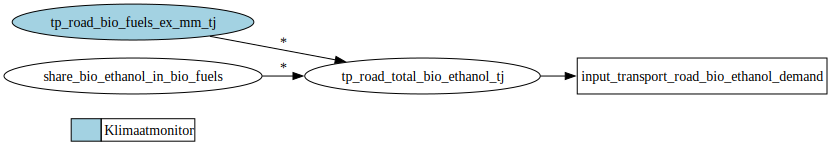

In [42]:
# Define ETLocal key
etlocal_key = "input_transport_road_bio_ethanol_demand"
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [43]:
def CommitMessage(output_description, arithmic, vars_description, sector, year, vars_source):
    def format_var(desc, source):
        return f"{desc} ({source}, {year})"

    # Handle None or empty input
    if not vars_description:
        return (
                f"{output_description} in the {sector} sector "
                f"({vars_source[0]}, {year})."
            )

    # 1 variable
    if len(vars_description) == 1:
        return (
            f"{output_description} in the {sector} sector is directly based on "
            f"{format_var(vars_description[0], vars_source[0])}."
        )
    
    # 2 variables
    elif len(vars_description) == 2:
        # Use arithmic[0] and arithmic[1] here assuming arithmic is a list with two elements
        if arithmic[-1] =='subtract':
            return (
                f"{output_description} in the {sector} sector is calculated by "
                f"{arithmic[1]}ing {format_var(vars_description[1], vars_source[1])} from "
                f"{format_var(vars_description[0], vars_source[0])}."
            )
        else:
            return (
                f"{output_description} in the {sector} sector is calculated by "
                f"{arithmic[1]}ing {format_var(vars_description[0], vars_source[0])} by "
                f"{format_var(vars_description[1], vars_source[1])}."
            )

    # 3 variables
    elif len(vars_description) == 3:
        return (
            f"{output_description} in the {sector} sector is calculated by first "
            f"{arithmic[0]}ing {format_var(vars_description[0], vars_source[0])} and "
            f"{format_var(vars_description[1], vars_source[1])}, and "
            f"{arithmic[2]}ing {format_var(vars_description[2], vars_source[2])}."
        )

    # 4 variables
    elif len(vars_description) == 4:
        return (
            f"{output_description} in the {sector} sector is calculated by {arithmic[0]}ing "
            f"{format_var(vars_description[0], vars_source[0])}, {format_var(vars_description[1], vars_source[1])}, "
            f"{format_var(vars_description[2], vars_source[2])}, and {format_var(vars_description[3], vars_source[3])}."
        )
    
    # 6 variables
    elif len(vars_description) == 6:
        return (
            f"{output_description} in the {sector} sector is calculated by {arithmic[0]}ing"
            f"{format_var(vars_description[0], vars_source[0])}, {format_var(vars_description[1], vars_source[1])}, "
            f"{format_var(vars_description[2], vars_source[2])}, {format_var(vars_description[3], vars_source[3])}, "
            f"{format_var(vars_description[4], vars_source[4])}, and "
            f"{format_var(vars_description[5], vars_source[5])}."
        )

    # Fallback
    else:
        return (
            f"{output_description} in the {sector} sector uses an unsupported number of variables "
            f"({len(vars_description)})."
        )


Read the information for the commit message from the image and write them down to generate the commit message.

In [44]:
sector = 'transport'
output_description = 'Final bio-ethanol demand'
arithmic_op= ['add','multiply']
vars_description = ['the total biofuel use in road transport (excluding mobile machinery)', 'the share of bio-ethanol in biofuels']
vars_source = ['Klimaatmonitor', 'co2emissiefactoren']


message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final bio-ethanol demand in the transport sector is calculated by multiplying the total biofuel use in road transport (excluding mobile machinery) (Klimaatmonitor, 2023) by the share of bio-ethanol in biofuels (co2emissiefactoren, 2023).


2. Calculate etlocal_key values
- *Action*: assign the output name from the image to `ivar`.

In [45]:

df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


input_transport_road_bio_ethanol_demand  \
GemeenteCode                                            
GM1680                                      37.239670   
GM0358                                      16.614622   
GM0197                                      13.177114   
GM0059                                      16.614622   
GM0482                                      13.177114   
...                                               ...   
GM0879                                      12.031278   
GM0301                                      20.052130   
GM1896                                      13.177114   
GM0642                                      22.343802   
GM0193                                      95.677307   

              tp_road_total_bio_ethanol_tj error_message  \
GemeenteCode                                               
GM1680                           37.239670           NaN   
GM0358                           16.614622           NaN   
GM0197                           13.177114           NaN   
GM0059                           16.614622           NaN   
GM0482                           13.177114           NaN   
...                                    ...           ...   
GM0879                           12.031278           NaN   
GM0301                           20.052130           NaN   
GM1896                           13.177114           NaN   
GM0642                           22.343802           NaN   
GM0193                           95.677307           NaN   

                                                         commit  
GemeenteCode                                                     
GM1680        Final bio-ethanol demand in the transport sect...  
GM0358        Final bio-ethanol demand in the transport sect...  
GM0197        Final bio-ethanol demand in the transport sect...  
GM0059        Final bio-ethanol demand in the transport sect...  
GM0482        Final bio-ethanol demand in the transport sect...  
...                                                         ...  
GM0879        Final bio-ethanol demand in the transport sect...  
GM0301        Final bio-ethanol demand in the transport sect...  
GM1896        Final bio-ethanol demand in the transport sect...  
GM0642        Final bio-ethanol demand in the transport sect...  
GM0193        Final bio-ethanol demand in the transport sect...  

[342 rows x 4 columns]

3. Add data to template

In [46]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)


4. Use validation function to quick-scan data.

In [47]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_road_bio_ethanol_demand',
 'total_rows': 342,
 'zero_count': 2,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 410.7822096587674,
 'mean_value': 38.346976768450595,
 'median_value': 27.21360524238696}

In [48]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_road_bio_ethanol_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 213 municipalities (63.0%)
  medium_diff: 104 municipalities (30.8%)
  small_diff: 20 municipalities (5.9%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=410.78, Mean=38.11
  Verification: Min=0.00, Max=403.95, Mean=42.85
  Abs diff:     Min=0.00, Max=52.09, Mean=5.54

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0394: Template=294.48, V

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0394      294.479855         346.574422     52.094568     -15.031279   
GM0344      225.156776         275.423382     50.266606     -18.250668   
GM0363      325.990345         360.345591     34.355246      -9.533972   
GM0758      166.146221         199.108153     32.961932     -16.554788   
GM0518      155.833697          187.05838     31.224683     -16.692480   
...                ...                ...           ...            ...   
GM0221        4.583344            4.59039      0.007046      -0.153487   
GM0755        4.010426           4.016591      0.006165      -0.153487   
GM0277        1.145836           1.147597      0.001761      -0.153487   
GM0060        1.145836           1.147597      0.001761      -0.153487   
GM0096        0.000000                  0           0.0       0.000000   

             status  
GM0394   large_diff  
GM0344   large_diff  
GM0363  medium_diff  
GM0758   large_diff  
GM0518   large_diff  
...             ...  
GM0221   small_diff  
GM0755   small_diff  
GM0277   small_diff  
GM0060   small_diff  
GM0096  exact_match  

[338 rows x 5 columns]

##### Road biodiesel demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

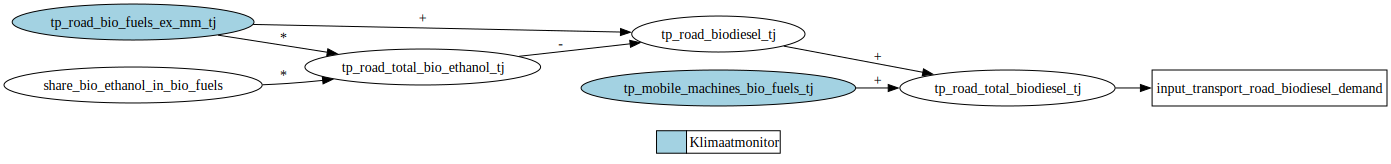

In [49]:
etlocal_key = 'input_transport_road_biodiesel_demand'
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [50]:
sector = 'transport'
output_description = 'Final biodiesel demand'
arithmic_op= ['add','add']
vars_description = ['total biodiesel use in road transport', 'total biofuel use of mobile machines']
vars_source = ['Klimaatmonitor', 'Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final biodiesel demand in the transport sector is calculated by adding total biodiesel use in road transport (Klimaatmonitor, 2023) to total biofuel use of mobile machines (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit message


In [51]:

df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


input_transport_road_biodiesel_demand  \
GemeenteCode                                          
GM1680                                    38.760330   
GM0358                                    16.385378   
GM0197                                    13.822886   
GM0059                                    16.385378   
GM0482                                    11.822886   
...                                             ...   
GM0879                                    14.968722   
GM0301                                    18.947870   
GM1896                                    13.822886   
GM0642                                    19.656198   
GM0193                                    84.322693   

              tp_road_total_bio_ethanol_tj  tp_road_biodiesel_tj  \
GemeenteCode                                                       
GM1680                           37.239670             27.760330   
GM0358                           16.614622             12.385378   
GM0197                           13.177114              9.822886   
GM0059                           16.614622             12.385378   
GM0482                           13.177114              9.822886   
...                                    ...                   ...   
GM0879                           12.031278              8.968722   
GM0301                           20.052130             14.947870   
GM1896                           13.177114              9.822886   
GM0642                           22.343802             16.656198   
GM0193                           95.677307             71.322693   

              tp_road_total_biodiesel_tj error_message  \
GemeenteCode                                             
GM1680                         38.760330           NaN   
GM0358                         16.385378           NaN   
GM0197                         13.822886           NaN   
GM0059                         16.385378           NaN   
GM0482                         11.822886           NaN   
...                                  ...           ...   
GM0879                         14.968722           NaN   
GM0301                         18.947870           NaN   
GM1896                         13.822886           NaN   
GM0642                         19.656198           NaN   
GM0193                         84.322693           NaN   

                                                         commit  
GemeenteCode                                                     
GM1680        Final biodiesel demand in the transport sector...  
GM0358        Final biodiesel demand in the transport sector...  
GM0197        Final biodiesel demand in the transport sector...  
GM0059        Final biodiesel demand in the transport sector...  
GM0482        Final biodiesel demand in the transport sector...  
...                                                         ...  
GM0879        Final biodiesel demand in the transport sector...  
GM0301        Final biodiesel demand in the transport sector...  
GM1896        Final biodiesel demand in the transport sector...  
GM0642        Final biodiesel demand in the transport sector...  
GM0193        Final biodiesel demand in the transport sector...  

[342 rows x 6 columns]

3. Add data to template

In [52]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [53]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_road_biodiesel_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 1.0,
 'max_value': 466.2177903412326,
 'mean_value': 35.95711679880087,
 'median_value': 26.635345729547183}

In [54]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_road_biodiesel_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 189 municipalities (55.9%)
  medium_diff: 133 municipalities (39.3%)
  small_diff: 16 municipalities (4.7%)

 VALUE STATISTICS:
  Template:     Min=1.00, Max=466.22, Mean=35.73
  Verification: Min=0.00, Max=478.05, Mean=39.49
  Abs diff:     Min=0.01, Max=49.64, Mean=4.58

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0363: Template=301.01, Verification=350.65, Diff=49.64 (-14.2%)
 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0363      301.009655         350.654409     49.644754     -14.157744   
GM0518      140.166303          187.94162     47.775317     -25.420297   
GM0344      198.843224         239.576618     40.733394     -17.002241   
GM0394      246.520145         277.425578     30.905432     -11.140080   
GM0758      138.853779         166.891847     28.038068     -16.800143   
...                ...                ...           ...            ...   
GM0678       15.666624          15.638441      0.028183       0.180214   
GM0399       13.104132          13.081233      0.022898       0.175048   
GM0498       12.968722          12.950227      0.018495       0.142815   
GM0221        4.416656            4.40961      0.007046       0.159780   
GM0755        4.989574           4.983409      0.006165       0.123710   

            status  
GM0363  large_diff  
GM0518  large_diff  
GM0344  large_diff  
GM0394  large_diff  
GM0758  large_diff  
...            ...  
GM0678  small_diff  
GM0399  small_diff  
GM0498  small_diff  
GM0221  small_diff  
GM0755  small_diff  

[338 rows x 5 columns]

##### Road gasoline demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

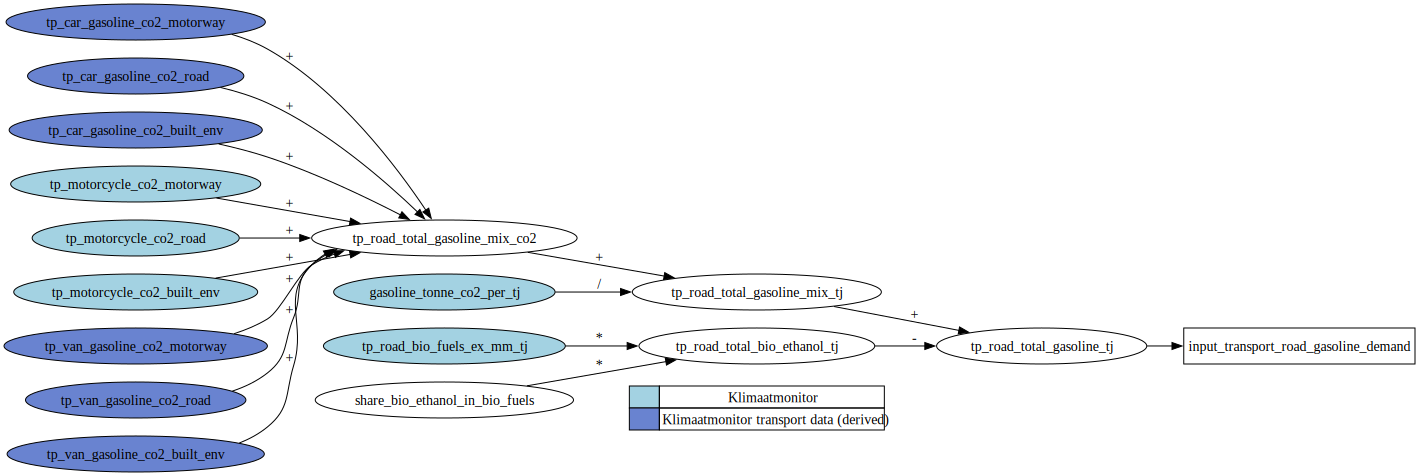

In [55]:
etlocal_key = 'input_transport_road_gasoline_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [56]:
# calculate tp_road_total_gasoline_mix_co2 as sum of columns below including index in df_input_vars

# create df_check as empty dataframe with same index as df_input_vars
df_check = pd.DataFrame(index=df_input_vars.index)

# print the value of each column used in the sum for municipality GM0363
print("Values for municipality GM0363:")
columns_to_sum = [
    'tp_car_gasoline_co2_motorway',
    'tp_car_gasoline_co2_road',
    'tp_car_gasoline_co2_built_env',
    'tp_motorcycle_co2_motorway',
    'tp_motorcycle_co2_road',
    'tp_motorcycle_co2_built_env',
    'tp_van_gasoline_co2_motorway',
    'tp_van_gasoline_co2_road',
    'tp_van_gasoline_co2_built_env'
]
for col in columns_to_sum:
    value = df_input_vars.at['GM0363', col]
    print(f"{col}: {value}")

df_check['tp_road_total_gasoline_mix_co2'] = (
    df_input_vars['tp_car_gasoline_co2_motorway'] +
    df_input_vars['tp_car_gasoline_co2_road'] +
    df_input_vars['tp_car_gasoline_co2_built_env'] +
    df_input_vars['tp_motorcycle_co2_motorway'] +
    df_input_vars['tp_motorcycle_co2_road'] +
    df_input_vars['tp_motorcycle_co2_built_env'] +
    df_input_vars['tp_van_gasoline_co2_motorway'] +
    df_input_vars['tp_van_gasoline_co2_road'] +
    df_input_vars['tp_van_gasoline_co2_built_env']
)

# DEBUG show result for municipality GM0363
df_check[df_check.index == 'GM0363']

Values for municipality GM0363:
tp_car_gasoline_co2_motorway: 181145.0788
tp_car_gasoline_co2_road: 85228.02608
tp_car_gasoline_co2_built_env: 188722.9432
tp_motorcycle_co2_motorway: 2770.0
tp_motorcycle_co2_road: 1920.0
tp_motorcycle_co2_built_env: 3577.0
tp_van_gasoline_co2_motorway: 2346.602307
tp_van_gasoline_co2_road: 824.2101565
tp_van_gasoline_co2_built_env: 1202.290872


tp_road_total_gasoline_mix_co2
GemeenteCode                                
GM0363                         467736.151415

Describe output key for the commit message by describing the last step:

In [57]:
sector = 'transport'
output_description = 'Final gasoline demand road transport'
arithmic_op= ['add','subtract'] #options: ['add', 'subtract', 'multiply']
vars_description = ['final gasoline demand road transport', 'final bio-ethanol demand road transport']
vars_source = ['Klimaatmonitor', 'Klimaatmonitor']

message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final gasoline demand road transport in the transport sector is calculated by subtracting final bio-ethanol demand road transport (Klimaatmonitor, 2023) from final gasoline demand road transport (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [58]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_transport_road_gasoline_demand  \
GemeenteCode                                         
GM1680                                  681.067719   
GM0358                                  320.626915   
GM0197                                  254.004791   
GM0059                                  317.316149   
GM0482                                  248.991275   
...                                            ...   
GM0879                                  238.694918   
GM0301                                  392.828457   
GM1896                                  252.799242   
GM0642                                  428.100029   
GM0193                                 1805.225054   

              tp_road_total_gasoline_mix_co2  tp_road_total_gasoline_mix_tj  \
GemeenteCode                                                                  
GM1680                          51804.497752                     718.307389   
GM0358                          24321.938926                     337.241537   
GM0197                          19269.221823                     267.181905   
GM0059                          24083.165718                     333.930771   
GM0482                          18907.645884                     262.168390   
...                                      ...                            ...   
GM0879                          18082.432199                     250.726196   
GM0301                          29777.044984                     412.880587   
GM1896                          19182.277295                     265.976356   
GM0642                          32486.114978                     450.443831   
GM0193                         137093.525055                    1900.902360   

              tp_road_total_bio_ethanol_tj  tp_road_total_gasoline_tj  \
GemeenteCode                                                            
GM1680                           37.239670                 681.067719   
GM0358                           16.614622                 320.626915   
GM0197                           13.177114                 254.004791   
GM0059                           16.614622                 317.316149   
GM0482                           13.177114                 248.991275   
...                                    ...                        ...   
GM0879                           12.031278                 238.694918   
GM0301                           20.052130                 392.828457   
GM1896                           13.177114                 252.799242   
GM0642                           22.343802                 428.100029   
GM0193                           95.677307                1805.225054   

             error_message                                             commit  
GemeenteCode                                                                   
GM1680                 NaN  Final gasoline demand road transport in the tr...  
GM0358                 NaN  Final gasoline demand road transport in the tr...  
GM0197                 NaN  Final gasoline demand road transport in the tr...  
GM0059                 NaN  Final gasoline demand road transport in the tr...  
GM0482                 NaN  Final gasoline demand road transport in the tr...  
...                    ...                                                ...  
GM0879                 NaN  Final gasoline demand road transport in the tr...  
GM0301                 NaN  Final gasoline demand road transport in the tr...  
GM1896                 NaN  Final gasoline demand road transport in the tr...  
GM0642                 NaN  Final gasoline demand road transport in the tr...  
GM0193                 NaN  Final gasoline demand road transport in the tr...  

[342 rows x 7 columns]

3. Add data to template

In [59]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [60]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_road_gasoline_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 1.1949397469975467,
 'max_value': 7868.41751047315,
 'mean_value': 724.6407688576039,
 'median_value': 512.0550624819886}

In [61]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_road_gasoline_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 255 municipalities (75.4%)
  medium_diff: 70 municipalities (20.7%)
  small_diff: 13 municipalities (3.8%)

 VALUE STATISTICS:
  Template:     Min=1.19, Max=7868.42, Mean=720.05
  Verification: Min=0.00, Max=5746.36, Mean=610.59
  Abs diff:     Min=0.28, Max=2122.06, Mean=114.22

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=7868.42, Verification=5746.36, Diff=2122.06 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599     7868.417510        5746.358493   2122.059017      36.928761   
GM0772     3669.060344        2859.994239    809.066105      28.289082   
GM0363     6159.514743        5501.359489    658.155254      11.963502   
GM0439      981.923466         382.483499    599.439967     156.723092   
GM0200     3555.595460        2990.340106    565.255354      18.902711   
...                ...                ...           ...            ...   
GM0096        1.194940                  0       1.19494       0.000000   
GM0553      135.658693         134.829448      0.829245       0.615033   
GM0327      460.300897         459.635471      0.665426       0.144773   
GM0986      187.645298         187.214094      0.431204       0.230327   
GM0575      371.522998         371.242144      0.280854       0.075652   

            status  
GM0599  large_diff  
GM0772  large_diff  
GM0363  large_diff  
GM0439  large_diff  
GM0200  large_diff  
...            ...  
GM0096  small_diff  
GM0553  small_diff  
GM0327  small_diff  
GM0986  small_diff  
GM0575  small_diff  

[338 rows x 5 columns]

Road gasoline demand is a component of the road electricity calculation. To support this, we create a copy of the final keys from the relevant dataframe for use in the road electricity calculation.

In [62]:
final_demand_road_gasoline_df = df_pipeline[['tp_road_total_gasoline_tj']].copy()
total_final_demand_road_gasoline_tj_NL = final_demand_road_gasoline_df['tp_road_total_gasoline_tj'].sum()
final_demand_road_gasoline_df['final_demand_road_gasoline_tj_share_NL'] = (
    final_demand_road_gasoline_df['tp_road_total_gasoline_tj'] / total_final_demand_road_gasoline_tj_NL
)
final_demand_road_gasoline_df = final_demand_road_gasoline_df.drop(columns=['tp_road_total_gasoline_tj'])

final_demand_road_gasoline_df.head()


final_demand_road_gasoline_tj_share_NL
GemeenteCode                                        
GM1680                                      0.002748
GM0358                                      0.001294
GM0197                                      0.001025
GM0059                                      0.001280
GM0482                                      0.001005

Export this dataframe to /data/intermediate, since Buildings will use these shares.

In [63]:
# from pathlib import Path

# Maak het pad aan als het nog niet bestaat
path = Path("data", "intermediate")
path.mkdir(parents=True, exist_ok=True)

# Bestandsnaam definiëren
file_path = path / "shares_cars_road_transport_gasoline_electricity.csv"

# Exporteer de dataframe naar het bestand
final_demand_road_gasoline_df.to_csv(file_path, index=True)


##### Road diesel demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

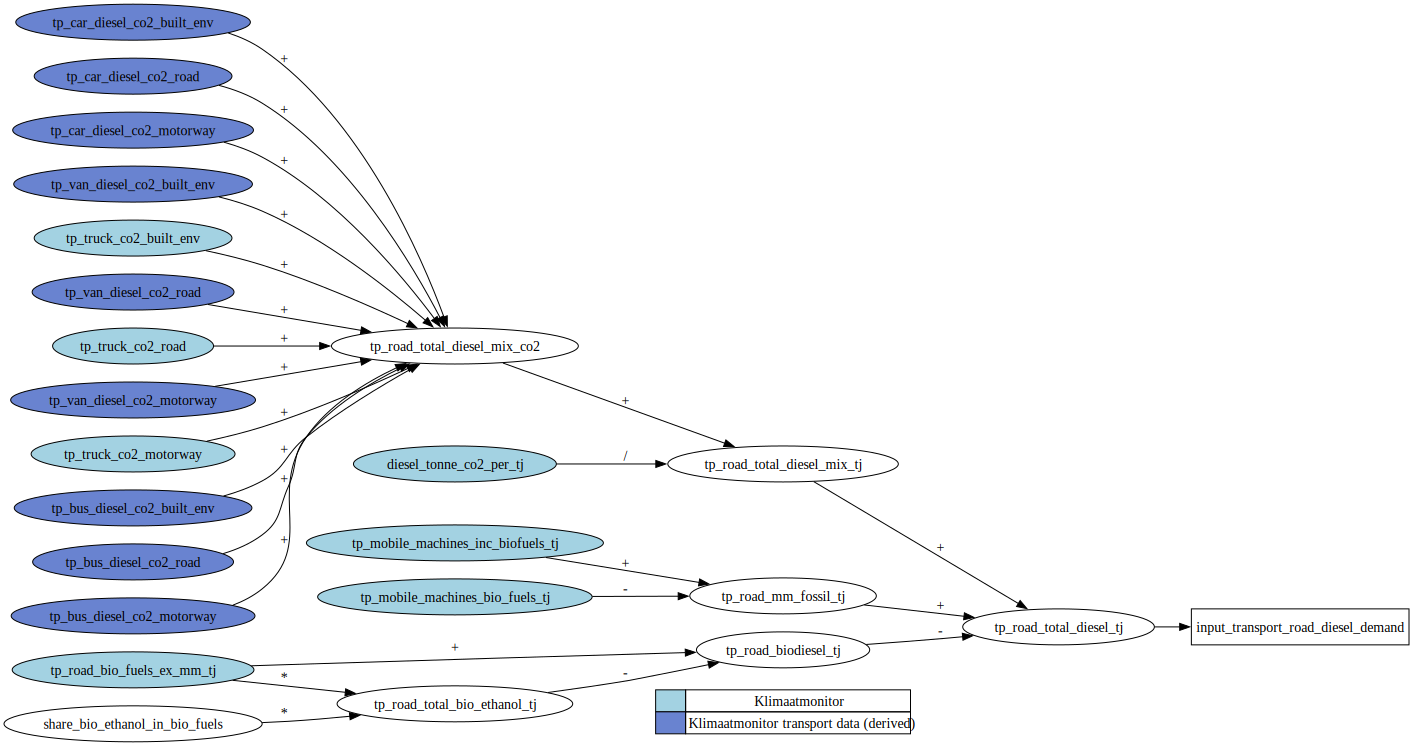

In [64]:
etlocal_key = 'input_transport_road_diesel_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [65]:
sector = 'transport'
output_description = 'Final diesel demand road transport'
arithmic_op= ['add','add', 'subtract'] #options: ['add', 'subtract', 'multiply']
vars_description = ['final diesel demand road transport', 'final diesel demand mobile machinery road transport', 'final biodiesel demand road transport']
vars_source = ['Klimaatmonitor', 'Klimaatmonitor', 'Klimaatmonitor']

message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final diesel demand road transport in the transport sector is calculated by first adding final diesel demand road transport (Klimaatmonitor, 2023) and final diesel demand mobile machinery road transport (Klimaatmonitor, 2023), and subtracting final biodiesel demand road transport (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [66]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_transport_road_diesel_demand  \
GemeenteCode                                       
GM1680                                823.528545   
GM0358                                264.591996   
GM0197                                244.339778   
GM0059                                276.512336   
GM0482                                263.014208   
...                                          ...   
GM0879                                248.754198   
GM0301                                288.518797   
GM1896                                244.536589   
GM0642                                355.607646   
GM0193                               1683.231361   

              tp_road_total_diesel_mix_co2  tp_road_total_diesel_mix_tj  \
GemeenteCode                                                              
GM1680                        47264.598070                   631.288875   
GM0358                        17443.016009                   232.977374   
GM0197                        13563.648659                   181.162664   
GM0059                        15715.041842                   209.897714   
GM0482                        15785.373234                   210.837094   
...                                    ...                          ...   
GM0879                        11958.455014                   159.722920   
GM0301                        18977.049319                   253.466666   
GM1896                        13877.863891                   185.359475   
GM0642                        23828.413980                   318.263844   
GM0193                       113843.882055                  1520.554054   

              tp_road_mm_fossil_tj  tp_road_total_bio_ethanol_tj  \
GemeenteCode                                                       
GM1680                       220.0                     37.239670   
GM0358                        44.0                     16.614622   
GM0197                        73.0                     13.177114   
GM0059                        79.0                     16.614622   
GM0482                        62.0                     13.177114   
...                            ...                           ...   
GM0879                        98.0                     12.031278   
GM0301                        50.0                     20.052130   
GM1896                        69.0                     13.177114   
GM0642                        54.0                     22.343802   
GM0193                       234.0                     95.677307   

              tp_road_biodiesel_tj  tp_road_total_diesel_tj error_message  \
GemeenteCode                                                                
GM1680                   27.760330               823.528545           NaN   
GM0358                   12.385378               264.591996           NaN   
GM0197                    9.822886               244.339778           NaN   
GM0059                   12.385378               276.512336           NaN   
GM0482                    9.822886               263.014208           NaN   
...                            ...                      ...           ...   
GM0879                    8.968722               248.754198           NaN   
GM0301                   14.947870               288.518797           NaN   
GM1896                    9.822886               244.536589           NaN   
GM0642                   16.656198               355.607646           NaN   
GM0193                   71.322693              1683.231361           NaN   

                                                         commit  
GemeenteCode                                                     
GM1680        Final diesel demand road transport in the tran...  
GM0358        Final diesel demand road transport in the tran...  
GM0197        Final diesel demand road transport in the tran...  
GM0059        Final diesel demand road transport in the tran...  
GM0482        Final diesel demand road transport in the tran...  
...         

3. Add data to template

In [67]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [68]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_road_diesel_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 30.11712473225732,
 'max_value': 7974.717503892772,
 'mean_value': 688.7015308915473,
 'median_value': 502.4612349720215}

In [69]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_road_diesel_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  medium_diff: 162 municipalities (47.9%)
  large_diff: 151 municipalities (44.7%)
  small_diff: 25 municipalities (7.4%)

 VALUE STATISTICS:
  Template:     Min=30.12, Max=7974.72, Mean=684.34
  Verification: Min=3.00, Max=8020.62, Mean=668.30
  Abs diff:     Min=0.05, Max=599.35, Mean=61.80

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0518: Template=2209.51, Verification=2808.87, Diff=599.35 (-2

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0518     2209.513633        2808.867398    599.353765     -21.337916   
GM0439      842.819842         386.895049    455.924793     117.841982   
GM1681      674.486659         286.476309    388.010351     135.442387   
GM0200     3541.089707        3163.615268    377.474439      11.931743   
GM0109     1085.400322          723.93491    361.465412      49.930651   
...                ...                ...           ...            ...   
GM0243      678.329425         677.525711      0.803714       0.118625   
GM1724      223.138848         222.396767      0.742081       0.333674   
GM0988      947.995140         948.650228      0.655089      -0.069055   
GM1640      840.722296         840.905025       0.18273      -0.021730   
GM0717      261.117813         261.070281      0.047532       0.018206   

            status  
GM0518  large_diff  
GM0439  large_diff  
GM1681  large_diff  
GM0200  large_diff  
GM0109  large_diff  
...            ...  
GM0243  small_diff  
GM1724  small_diff  
GM0988  small_diff  
GM1640  small_diff  
GM0717  small_diff  

[338 rows x 5 columns]

##### Road LPG demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

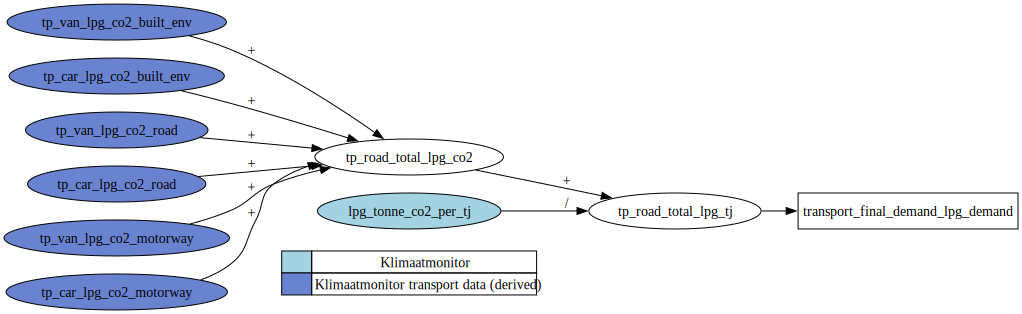

In [70]:
etlocal_key = 'transport_final_demand_lpg_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [71]:
sector = 'transport'
output_description = 'Final LPG demand road transport'
arithmic_op= ['add','divid'] #options: ['add', 'subtract', 'multiply', 'divid']
vars_description = ['the CO2 emissions LPG in road transport', 'the emission factor of LPG']
vars_source = ['Klimaatmonitor', 'Klimaatmonitor']

# message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
message = "Final LPG demand road transport in the transport sector is calculated by dividing the CO2 emissions of LPG in road transport (Klimaatmonitor, 2023) by the emission factor of LPG (Klimaatmonitor, 2023)."
print(message)



Final LPG demand road transport in the transport sector is calculated by dividing the CO2 emissions of LPG in road transport (Klimaatmonitor, 2023) by the emission factor of LPG (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [72]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

transport_final_demand_lpg_demand  tp_road_total_lpg_co2  \
GemeenteCode                                                             
GM1680                                14.076938             938.931753   
GM0358                                 5.967358             398.022782   
GM0197                                 4.878375             325.387614   
GM0059                                 6.078363             405.426790   
GM0482                                 5.024685             335.146506   
...                                         ...                    ...   
GM0879                                 4.577322             305.307363   
GM0301                                 7.382841             492.435505   
GM1896                                 4.814802             321.147294   
GM0642                                 8.631180             575.699718   
GM0193                                36.351933            2424.673899   

              tp_road_total_lpg_tj error_message  \
GemeenteCode                                       
GM1680                   14.076938           NaN   
GM0358                    5.967358           NaN   
GM0197                    4.878375           NaN   
GM0059                    6.078363           NaN   
GM0482                    5.024685           NaN   
...                            ...           ...   
GM0879                    4.577322           NaN   
GM0301                    7.382841           NaN   
GM1896                    4.814802           NaN   
GM0642                    8.631180           NaN   
GM0193                   36.351933           NaN   

                                                         commit  
GemeenteCode                                                     
GM1680        Final LPG demand road transport in the transpo...  
GM0358        Final LPG demand road transport in the transpo...  
GM0197        Final LPG demand road transport in the transpo...  
GM0059        Final LPG demand road transport in the transpo...  
GM0482        Final LPG demand road transport in the transpo...  
...                                                         ...  
GM0879        Final LPG demand road transport in the transpo...  
GM0301        Final LPG demand road transport in the transpo...  
GM1896        Final LPG demand road transport in the transpo...  
GM0642        Final LPG demand road transport in the transpo...  
GM0193        Final LPG demand road transport in the transpo...  

[342 rows x 5 columns]

3. Add data to template

In [73]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [74]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'transport_final_demand_lpg_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 0.021067397451274363,
 'max_value': 156.06036147826083,
 'mean_value': 14.570510034404641,
 'median_value': 10.278670264842578}

In [75]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: transport_final_demand_lpg_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  medium_diff: 160 municipalities (47.3%)
  large_diff: 152 municipalities (45.0%)
  small_diff: 26 municipalities (7.7%)

 VALUE STATISTICS:
  Template:     Min=0.02, Max=156.06, Mean=14.48
  Verification: Min=0.00, Max=131.85, Mean=14.15
  Abs diff:     Min=0.00, Max=24.21, Mean=1.31

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=156.06, Verification=131.85, Diff=24.21 (18.4%)
  Muni

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599      156.060361         131.852204     24.208157      18.360070   
GM0439       19.724447           8.356547       11.3679     136.035850   
GM0518       58.140157           68.10397      9.963814     -14.630298   
GM0344       84.675888          93.927293      9.251405      -9.849538   
GM0394      112.802479         121.339373      8.536894      -7.035551   
...                ...                ...           ...            ...   
GM1711       19.038534          19.048588      0.010054      -0.052783   
GM0677        5.070435           5.060551      0.009884       0.195318   
GM1896        4.814802           4.805173      0.009629       0.200389   
GM0579        5.396068           5.399731      0.003662      -0.067826   
GM0534        2.316634           2.314653      0.001982       0.085609   

             status  
GM0599   large_diff  
GM0439   large_diff  
GM0518   large_diff  
GM0344  medium_diff  
GM0394  medium_diff  
...             ...  
GM1711   small_diff  
GM0677   small_diff  
GM1896   small_diff  
GM0579   small_diff  
GM0534   small_diff  

[338 rows x 5 columns]

##### Road electricity demand

This key uses a different methodology compared to the others. While all other keys (except electricity) are calculated using a top-down approach, the electricity key was previously calculated bottom-up. The updated method is as follows:

1. For each municipality, we calculate the share of electric cars relative to the total number of electric cars across all municipalities. (calculated in the dataframe `electric_cars_share`)
2. We assume this distribution also applies to the energy demand of electric vehicles. Therefore, we multiply the share from step (1) by the total national electricity demand for road transport in the Netherlands (using query key `dq_transport_final_demand_for_road_electricity`).

In [76]:
etlocal_key = 'input_transport_road_electricity_demand' 

In [77]:
final_demand_road_gasoline_df.head()
df_pipeline = final_demand_road_gasoline_df.copy()
total_road_electricity_demand_NL = float(df_ivar_eq_data['dq_transport_final_demand_for_road_electricity'].values[0])
print(f'Total road electricity demand NL: {total_road_electricity_demand_NL} TJ')
df_pipeline[etlocal_key] = df_pipeline.iloc[:,0] * total_road_electricity_demand_NL
df_pipeline['error_message'] = None
df_pipeline['commit'] = None

df_pipeline

Total road electricity demand NL: 7947.877999999999 TJ


final_demand_road_gasoline_tj_share_NL  \
GemeenteCode                                           
GM1680                                      0.002748   
GM0358                                      0.001294   
GM0197                                      0.001025   
GM0059                                      0.001280   
GM0482                                      0.001005   
...                                              ...   
GM0879                                      0.000963   
GM0301                                      0.001585   
GM1896                                      0.001020   
GM0642                                      0.001727   
GM0193                                      0.007284   

              input_transport_road_electricity_demand error_message commit  
GemeenteCode                                                                
GM1680                                      21.842011          None   None  
GM0358                                      10.282585          None   None  
GM0197                                       8.145997          None   None  
GM0059                                      10.176408          None   None  
GM0482                                       7.985212          None   None  
...                                               ...           ...    ...  
GM0879                                       7.655005          None   None  
GM0301                                      12.598106          None   None  
GM1896                                       8.107334          None   None  
GM0642                                      13.729274          None   None  
GM0193                                      57.894016          None   None  

[342 rows x 4 columns]

In [78]:
# Step 1 as described above
# electric_cars = df_ivar_data['no_electric_cars_fev'].copy()
# NL_electric_cars = sum(electric_cars)

# df_pipeline = electric_cars / NL_electric_cars
# df_pipeline = df_pipeline.to_frame(name='electric_cars_share_NL')
# df_pipeline

In [79]:

# total_road_electricity_demand_NL = float(df_ivar_eq_data['dq_transport_final_demand_for_road_electricity'].values[0])
# print(f'Total road electricity demand NL: {total_road_electricity_demand_NL} TJ')
# df_pipeline[etlocal_key] = df_pipeline.iloc[:,0] * total_road_electricity_demand_NL
# df_pipeline.head()

Compose commit message:

In [80]:
message = 'Final electricity demand for road transport is calculated by multiplying the municipal share of gasoline cars energy demand (relative to the national total) by the total national electricity demand for road transport (Klimaatmonitor, 2023).'
# df_pipeline['commit'] = message
# df_pipeline

# message = 'Final electricity demand road transport is calculated by multiplying municipal gasoline demand share with national electricity demand for road transport (2023).'
df_pipeline['commit'] = message
message

'Final electricity demand for road transport is calculated by multiplying the municipal share of gasoline cars energy demand (relative to the national total) by the total national electricity demand for road transport (Klimaatmonitor, 2023).'

3. Add data to template

In [81]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [82]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_road_electricity_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 0.03832201434219121,
 'max_value': 252.34210297577425,
 'mean_value': 23.23940935672514,
 'median_value': 16.4217329766893}

In [83]:
verification_results = src.helper.compare_template_with_verification(df_template_local,etlocal_key)
verification_results


MUNICIPALITY COMPARISON FOR KEY: input_transport_road_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 336 municipalities (99.4%)
  medium_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.04, Max=252.34, Mean=23.09
  Verification: Min=0.10, Max=249.32, Mean=6.55
  Abs diff:     Min=0.06, Max=185.38, Mean=19.04

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=252.34, Verification=66.96, Diff=185.38 (276.8%)
  Municipality GM0034: Template=73.55, V

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599      252.342103          66.964125    185.377978     276.831776   
GM0034       73.554183         249.315297    175.761114     -70.497525   
GM0402       23.075922         130.771488    107.695566     -82.354012   
GM0200      114.028829          16.338172     97.690657     597.928923   
GM0772      117.667676           20.22176     97.445916     481.886432   
...                ...                ...           ...            ...   
GM0448        2.340514           1.992696      0.347818      17.454643   
GM0093        1.092153           0.773341      0.318812      41.225292   
GM0088        0.080756           0.398448      0.317692     -79.732370   
GM0096        0.038322           0.099582       0.06126     -61.517100   
GM0060        0.726176           0.667988      0.058188       8.710986   

             status  
GM0599   large_diff  
GM0034   large_diff  
GM0402   large_diff  
GM0200   large_diff  
GM0772   large_diff  
...             ...  
GM0448   large_diff  
GM0093   large_diff  
GM0088   large_diff  
GM0096   large_diff  
GM0060  medium_diff  

[338 rows x 5 columns]

##### Road CNG demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

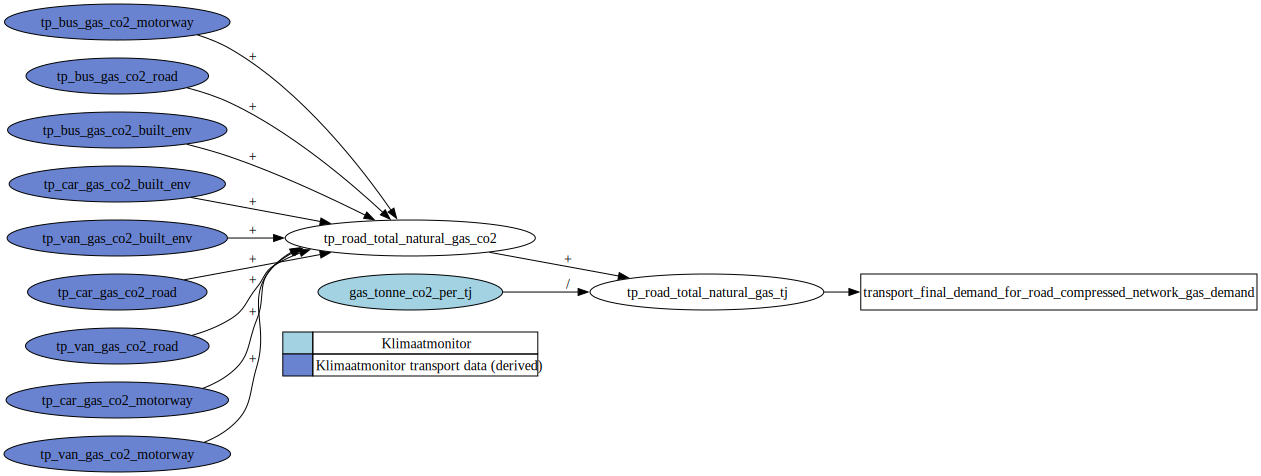

In [84]:
etlocal_key = 'transport_final_demand_for_road_compressed_network_gas_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [85]:
# key = 'tp_bus_gas_co2_road'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])
# # print(meta.loc[key, ['Bron']].iloc[0])

Describe output key for the commit message by describing the last step:

In [86]:
# sector = 'transport'
# output_description = 'Final compressed network gas demand road transport'
# arithmic_op= ['add','divid'] #options: ['add', 'subtract', 'multiply', 'divid']
# vars_description = ['the CO2 emissions CNG in road transport', 'the emission factor of CNG']
# vars_source = ['Klimaatmonitor', 'Klimaatmonitor']

# message = 'Final compressed network gas demand road transport in the transport sector is calculated by converting the CO2 emissions CNG in road transport (Klimaatmonitor, 2023) by the emission factor of CNG (Klimaatmonitor, 2023).'
message = "Final compressed network gas demand road transport in the transport sector is calculated by converting the CO2 emissions of CNG in road transport (Klimaatmonitor, 2023) by the emission factor of CNG (Klimaatmonitor, 2023)."
print(message)


Final compressed network gas demand road transport in the transport sector is calculated by converting the CO2 emissions of CNG in road transport (Klimaatmonitor, 2023) by the emission factor of CNG (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [87]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

transport_final_demand_for_road_compressed_network_gas_demand  \
GemeenteCode                                                                  
GM1680                                                 3.827243               
GM0358                                                 1.550632               
GM0197                                                 0.798261               
GM0059                                                 1.412089               
GM0482                                                 1.037498               
...                                                         ...               
GM0879                                                 0.864223               
GM0301                                                 1.452021               
GM1896                                                 1.111988               
GM0642                                                 1.458602               
GM0193                                                 7.771233               

              tp_road_total_natural_gas_co2  tp_road_total_natural_gas_tj  \
GemeenteCode                                                                
GM1680                           215.486457                      3.827243   
GM0358                            87.305744                      1.550632   
GM0197                            44.944767                      0.798261   
GM0059                            79.505302                      1.412089   
GM0482                            58.414596                      1.037498   
...                                     ...                           ...   
GM0879                            48.658615                      0.864223   
GM0301                            81.753616                      1.452021   
GM1896                            62.608634                      1.111988   
GM0642                            82.124132                      1.458602   
GM0193                           437.546219                      7.771233   

             error_message                                             commit  
GemeenteCode                                                                   
GM1680                 NaN  Final compressed network gas demand road trans...  
GM0358                 NaN  Final compressed network gas demand road trans...  
GM0197                 NaN  Final compressed network gas demand road trans...  
GM0059                 NaN  Final compressed network gas demand road trans...  
GM0482                 NaN  Final compressed network gas demand road trans...  
...                    ...                                                ...  
GM0879                 NaN  Final compressed network gas demand road trans...  
GM0301                 NaN  Final compressed network gas demand road trans...  
GM1896                 NaN  Final compressed network gas demand road trans...  
GM0642                 NaN  Final compressed network gas demand road trans...  
GM0193                 NaN  Final compressed network gas demand road trans...  

[342 rows x 5 columns]

3. Add data to template

In [88]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group     subgroup                  key                                                       
GM0014 transport transport_plane_transport bunkers_total_useful_demand_planes_demand            TJ   
                                           input_transport_plane_bio_ethanol_demand             TJ   
                                           input_transport_plane_electricity_demand             TJ   
                                           input_transport_plane_gasoline_demand                TJ   
                                           transport_final_demand_kerosene_demand               TJ   
...                                                                                            ...   
GM1992 transport transport_ship_transport  input_transport_ship_diesel_demand                   TJ   
                                           input_transport_ship_electricity_demand              TJ   
                                           transport_final_demand_for_shipping_bio_lng_demand   TJ   
                                           transport_final_demand_for_shipping_lng_demand       TJ   
                                           transport_final_demand_heavy_fuel_oil_demand         TJ   

                                                                                               value  \
geo_id group     subgroup                  key                                                         
GM0014 transport transport_plane_transport bunkers_total_useful_demand_planes_demand             NaN   
                                           input_transport_plane_bio_ethanol_demand              NaN   
                                           input_transport_plane_electricity_demand              NaN   
                                           input_transport_plane_gasoline_demand                 NaN   
                                           transport_final_demand_kerosene_demand                NaN   
...                                                                                              ...   
GM1992 transport transport_ship_transport  input_transport_ship_diesel_demand                    NaN   
                                           input_transport_ship_electricity_demand               NaN   
                                           transport_final_demand_for_shipping_bio_lng_demand    NaN   
                                           transport_final_demand_for_shipping_lng_demand        NaN   
                                           transport_final_demand_heavy_fuel_oil_demand          NaN   

                                                                                              commit  
geo_id group     subgroup                  key                                                        
GM0014 transport transport_plane_transport bunkers_total_useful_demand_planes_demand             nan  
                                           input_transport_plane_bio_ethanol_demand              nan  
                                           input_transport_plane_electricity_demand              nan  
                                           input_transport_plane_gasoline_demand                 nan  
                                           transport_final_demand_kerosene_demand                nan  
...                                                                                              ...  
GM1992 transport transport_ship_transport  input_transport_ship_diesel_demand                    nan  
                                           input_transport_ship_electricity_demand               nan  
                                           transport_final_demand_for_shipping_bio_lng_demand    nan  
                                           transport_final_demand_for_shipping_lng_demand        nan  
                                           transport_final_demand_heavy_fuel_oil_demand          nan  

[21888 rows x 3 columns]

4. Use validation function to quick-scan data

In [89]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'transport_final_demand_for_road_compressed_network_gas_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 0.03210364587692109,
 'max_value': 33.133695469625785,
 'mean_value': 2.8733316459347016,
 'median_value': 1.9398066905810252}

In [90]:
dataframe = src.helper.compare_template_with_verification(df_template_local,etlocal_key)
dataframe


MUNICIPALITY COMPARISON FOR KEY: transport_final_demand_for_road_compressed_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.03, Max=33.13, Mean=2.86
  Verification: Min=0.00, Max=1.73, Mean=0.11
  Abs diff:     Min=0.03, Max=31.41, Mean=2.76

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0363: Template=33.13, Verification=1.73, Diff=31.41 (1817.9%)
  Municipality GM0599: Template=27.30, Verification=0.81, Diff=2

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0363       33.133695           1.727577     31.406119    1817.929218   
GM0599       27.300630           0.811608     26.489022    3263.771467   
GM0394       23.378519            0.94122     22.437299    2383.853229   
GM0344       21.492085           1.051578     20.440506    1943.793082   
GM0772       14.135425           0.536566     13.598859    2534.424493   
...                ...                ...           ...            ...   
GM0093        0.189556           0.012614      0.176941    1402.721354   
GM0060        0.186890            0.01461       0.17228    1179.205120   
GM0277        0.084414           0.004135      0.080279    1941.389978   
GM0088        0.046949           0.003369       0.04358    1293.450626   
GM0096        0.032104           0.004494      0.027609     614.319952   

            status  
GM0363  large_diff  
GM0599  large_diff  
GM0394  large_diff  
GM0344  large_diff  
GM0772  large_diff  
...            ...  
GM0093  large_diff  
GM0060  large_diff  
GM0277  large_diff  
GM0088  large_diff  
GM0096  large_diff  

[338 rows x 5 columns]

In [91]:
dataframe['verification_value'].sum()

35.733436975

##### Road hydrogen demand

This key uses a different methodology compared to the others. While all other keys (except electricity and hydrogen) are calculated using a top-down approach, the hydrogen key was previously calculated bottom-up. The updated method is as follows:

1. For each municipality, we calculate the share of gasoline cars relative to the total number of gasoline cars across all municipalities. (calculated in the dataframe `final_demand_road_gasoline_df`). The result serves as a proxy distribution key.
2. We assume this distribution also applies to electric vehicles. Therefore, we multiply the share from step (1) by the total national electricity demand for road transport in the Netherlands (using query key `dq_transport_final_demand_for_road_electricity`).

In [92]:
etlocal_key = 'transport_final_demand_hydrogen_demand' 

final_demand_road_gasoline_df.head()
df_pipeline = final_demand_road_gasoline_df.copy()
total_road_hydrogen_demand_NL = float(df_ivar_eq_data['dq_transport_final_demand_for_road_hydrogen'].values[0])
print(f'Total road hydrogen demand NL: {total_road_hydrogen_demand_NL} TJ')
df_pipeline[etlocal_key] = df_pipeline.iloc[:,0] * total_road_hydrogen_demand_NL
df_pipeline['error_message'] = None
df_pipeline['commit'] = None

df_pipeline



Total road hydrogen demand NL: 0.0 TJ


final_demand_road_gasoline_tj_share_NL  \
GemeenteCode                                           
GM1680                                      0.002748   
GM0358                                      0.001294   
GM0197                                      0.001025   
GM0059                                      0.001280   
GM0482                                      0.001005   
...                                              ...   
GM0879                                      0.000963   
GM0301                                      0.001585   
GM1896                                      0.001020   
GM0642                                      0.001727   
GM0193                                      0.007284   

              transport_final_demand_hydrogen_demand error_message commit  
GemeenteCode                                                               
GM1680                                           0.0          None   None  
GM0358                                           0.0          None   None  
GM0197                                           0.0          None   None  
GM0059                                           0.0          None   None  
GM0482                                           0.0          None   None  
...                                              ...           ...    ...  
GM0879                                           0.0          None   None  
GM0301                                           0.0          None   None  
GM1896                                           0.0          None   None  
GM0642                                           0.0          None   None  
GM0193                                           0.0          None   None  

[342 rows x 4 columns]

Compose commit message:

In [93]:
message = 'Final electricity demand for road transport is calculated by multiplying the municipal share of gasoline cars energy demand (relative to the national total) by the total national hydrogen demand for road transport (Klimaatmonitor, 2023).'
df_pipeline['commit'] = message
message

'Final electricity demand for road transport is calculated by multiplying the municipal share of gasoline cars energy demand (relative to the national total) by the total national hydrogen demand for road transport (Klimaatmonitor, 2023).'

3. Add data to template

In [94]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [95]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'transport_final_demand_hydrogen_demand',
 'total_rows': 342,
 'zero_count': 342,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 0.0,
 'mean_value': 0.0,
 'median_value': 0.0}

In [96]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: transport_final_demand_hydrogen_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 274 municipalities (81.1%)
  large_diff: 64 municipalities (18.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=1.62, Mean=0.04
  Abs diff:     Min=0.00, Max=1.62, Mean=0.04

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0202: Template=0.00, Verification=1.62, Diff=1.62 (-100.0%)
  Municipality GM0307: Template=0.00, Verification=

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0202             0.0           1.616087      1.616087         -100.0   
GM0307             0.0               1.44          1.44         -100.0   
GM0772             0.0               1.44          1.44         -100.0   
GM1961             0.0           1.017391      1.017391         -100.0   
GM0014             0.0           0.996076      0.996076         -100.0   
...                ...                ...           ...            ...   
GM0579             0.0                  0           0.0            0.0   
GM0589             0.0                  0           0.0            0.0   
GM0590             0.0                  0           0.0            0.0   
GM0597             0.0                  0           0.0            0.0   
GM0687             0.0                  0           0.0            0.0   

             status  
GM0202   large_diff  
GM0307   large_diff  
GM0772   large_diff  
GM1961   large_diff  
GM0014   large_diff  
...             ...  
GM0579  exact_match  
GM0589  exact_match  
GM0590  exact_match  
GM0597  exact_match  
GM0687  exact_match  

[338 rows x 5 columns]

##### Rail diesel demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

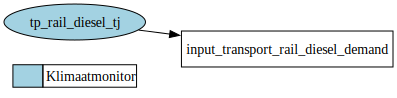

In [97]:
etlocal_key = 'input_transport_rail_diesel_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


Describe output key for the commit message by describing the last step:

In [98]:
# sector = 'transport'
# output_description = 'Final diesel demand rail transport'
# arithmic_op= ['add']
# vars_description = ['']
# vars_source = ['Klimaatmonitor']
message = 'Final diesel demand rail transport in the transport sector is directly retrieved from Klimaatmonitor (2023).'

# message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Final diesel demand rail transport in the transport sector is directly retrieved from Klimaatmonitor (2023).


2. Calculate etlocal_key values and add commit messages

In [99]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_transport_rail_diesel_demand error_message  \
GemeenteCode                                                     
GM1680                                       0.0           NaN   
GM0358                                       0.0           NaN   
GM0197                                      10.0           NaN   
GM0059                                      13.0           NaN   
GM0482                                       0.0           NaN   
...                                          ...           ...   
GM0879                                       0.0           NaN   
GM0301                                      10.0           NaN   
GM1896                                       0.0           NaN   
GM0642                                      53.0           NaN   
GM0193                                       0.0           NaN   

                                                         commit  
GemeenteCode                                                     
GM1680        Final diesel demand rail transport in the tran...  
GM0358        Final diesel demand rail transport in the tran...  
GM0197        Final diesel demand rail transport in the tran...  
GM0059        Final diesel demand rail transport in the tran...  
GM0482        Final diesel demand rail transport in the tran...  
...                                                         ...  
GM0879        Final diesel demand rail transport in the tran...  
GM0301        Final diesel demand rail transport in the tran...  
GM1896        Final diesel demand rail transport in the tran...  
GM0642        Final diesel demand rail transport in the tran...  
GM0193        Final diesel demand rail transport in the tran...  

[342 rows x 3 columns]

3. Add data to template

In [100]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [101]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_rail_diesel_demand',
 'total_rows': 342,
 'zero_count': 279,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 103.0,
 'mean_value': 2.915204678362573,
 'median_value': 0.0}

In [102]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)



MUNICIPALITY COMPARISON FOR KEY: input_transport_rail_diesel_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 284 municipalities (84.0%)
  large_diff: 54 municipalities (16.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=103.00, Mean=2.85
  Verification: Min=0.00, Max=141.00, Mean=2.91
  Abs diff:     Min=0.00, Max=38.00, Mean=0.95

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=103.00, Verification=141.00, Diff=38.00 (-27.0%)
  Municipality GM1960: Template=58.00, Verific

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599           103.0                141          38.0     -26.950355   
GM1960            58.0                 80          22.0     -27.500000   
GM0642            53.0                 73          20.0     -27.397260   
GM0489            47.0                 64          17.0     -26.562500   
GM1740            38.0                 52          14.0     -26.923077   
...                ...                ...           ...            ...   
GM0437             0.0                  0           0.0       0.000000   
GM0432             0.0                  0           0.0       0.000000   
GM0431             0.0                  0           0.0       0.000000   
GM0420             0.0                  0           0.0       0.000000   
GM0622             0.0                  0           0.0       0.000000   

             status  
GM0599   large_diff  
GM1960   large_diff  
GM0642   large_diff  
GM0489   large_diff  
GM1740   large_diff  
...             ...  
GM0437  exact_match  
GM0432  exact_match  
GM0431  exact_match  
GM0420  exact_match  
GM0622  exact_match  

[338 rows x 5 columns]

Rail diesel demand is a component of the rail biodiesel calculation. To support this, we create a copy of the final keys from the relevant dataframe for use in the rail biodiesel calculation.

In [103]:
final_demand_rail_diesel_df = df_pipeline[['input_transport_rail_diesel_demand']].copy()
total_final_demand_rail_diesel_tj_NL = final_demand_rail_diesel_df['input_transport_rail_diesel_demand'].sum()
final_demand_rail_diesel_df['final_demand_rail_diesel_tj_share_NL'] = (
    final_demand_rail_diesel_df['input_transport_rail_diesel_demand'] / total_final_demand_rail_diesel_tj_NL
)
final_demand_rail_diesel_df = final_demand_rail_diesel_df.drop(columns=['input_transport_rail_diesel_demand'])
final_demand_rail_diesel_df.head()

final_demand_rail_diesel_tj_share_NL
GemeenteCode                                      
GM1680                                    0.000000
GM0358                                    0.000000
GM0197                                    0.010030
GM0059                                    0.013039
GM0482                                    0.000000

##### Rail biodiesel demand

This key uses a different methodology compared to the others. While all other keys (except electricity and hydrogen) are calculated using a top-down approach, the biodiesel (rails) key was previously calculated bottom-up. The updated method is as follows:

1. For each municipality, we calculate the share of diesel trains relative to the total number of diesel trains across all municipalities. (calculated in the dataframe `final_demand_rail_diesel_df`)
2. We assume this distribution also applies to biodiesel trains. Therefore, we multiply the share from step (1) by the total national biodiesel demand for rail transport in the Netherlands (using query key `dq_transport_final_demand_for_rail_biodiesel`).

In [104]:
etlocal_key = 'input_transport_rail_biodiesel_demand' 

df_pipeline = final_demand_rail_diesel_df.copy()

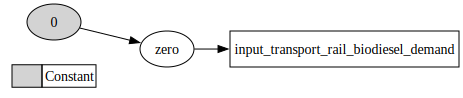

In [105]:
etlocal_key = 'input_transport_rail_biodiesel_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [106]:
total_rail_biodiesel_demand_NL = float(df_ivar_eq_data['dq_transport_final_demand_for_rail_biodiesel'].values[0])
print(f'Total rail biodiesel demand NL: {total_rail_biodiesel_demand_NL} TJ')
df_pipeline[etlocal_key] = df_pipeline.iloc[:,0] * total_rail_biodiesel_demand_NL
df_pipeline['error_message'] = None
df_pipeline['commit'] = None
message = 'Final biodiesel demand rail transport is calculated by multiplying municipal diesel demand share (Klimaatmonitor, 2023) with national biodiesel demand for rail transport (Klimaatmonitor, 2023).'
df_pipeline['commit'] = message
df_pipeline.head()

Total rail biodiesel demand NL: 65.67700000000005 TJ


final_demand_rail_diesel_tj_share_NL  \
GemeenteCode                                         
GM1680                                    0.000000   
GM0358                                    0.000000   
GM0197                                    0.010030   
GM0059                                    0.013039   
GM0482                                    0.000000   

              input_transport_rail_biodiesel_demand error_message  \
GemeenteCode                                                        
GM1680                                     0.000000          None   
GM0358                                     0.000000          None   
GM0197                                     0.658746          None   
GM0059                                     0.856370          None   
GM0482                                     0.000000          None   

                                                         commit  
GemeenteCode                                                     
GM1680        Final biodiesel demand rail transport is calcu...  
GM0358        Final biodiesel demand rail transport is calcu...  
GM0197        Final biodiesel demand rail transport is calcu...  
GM0059        Final biodiesel demand rail transport is calcu...  
GM0482        Final biodiesel demand rail transport is calcu...

3. Add data to template

In [107]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [108]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_rail_biodiesel_demand',
 'total_rows': 342,
 'zero_count': 279,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 6.785086258776334,
 'mean_value': 0.1920380116959066,
 'median_value': 0.0}

In [109]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_rail_biodiesel_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 276 municipalities (81.7%)
  small_diff: 62 municipalities (18.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=6.79, Mean=0.19
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=6.79, Mean=0.19

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=6.79, Verification=0.00, Diff=6.79 (0.0%)
  Municipality GM1960: Template=3.82, Verification=0.00

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599        6.785086                  0      6.785086            0.0   
GM1960        3.820728                  0      3.820728            0.0   
GM0642        3.491355                  0      3.491355            0.0   
GM0489        3.096107                  0      3.096107            0.0   
GM0014        2.634985                  0      2.634985            0.0   
...                ...                ...           ...            ...   
GM0451        0.000000                  0           0.0            0.0   
GM0450        0.000000                  0           0.0            0.0   
GM0448        0.000000                  0           0.0            0.0   
GM0441        0.000000                  0           0.0            0.0   
GM0622        0.000000                  0           0.0            0.0   

             status  
GM0599   small_diff  
GM1960   small_diff  
GM0642   small_diff  
GM0489   small_diff  
GM0014   small_diff  
...             ...  
GM0451  exact_match  
GM0450  exact_match  
GM0448  exact_match  
GM0441  exact_match  
GM0622  exact_match  

[338 rows x 5 columns]

##### Rail electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

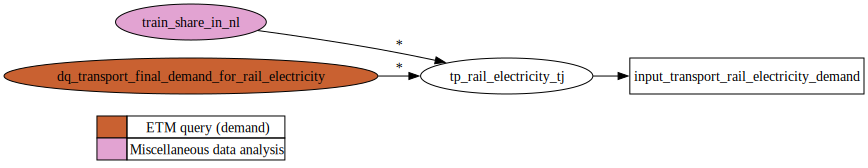

In [110]:
etlocal_key = 'input_transport_rail_electricity_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [111]:
sector = 'transport'
output_description = 'Final electricity demand rail transport'
arithmic_op= ['add','muliply']
vars_description = ['the municipal train share', 'final national electricity demand rail transport']
vars_source = ['NS Dashboard', 'CBS']

# message = CommitMessage(output_description,arithmic_op,vars_description,sector,year,vars_source)
message = "Final electricity demand rail transport in the transport sector is calculated by multiplying the municipal train share (NS Dashboard, 2023) by final national electricity demand rail transport (CBS, 2023)."
print(message)

Final electricity demand rail transport in the transport sector is calculated by multiplying the municipal train share (NS Dashboard, 2023) by final national electricity demand rail transport (CBS, 2023).


2. Calculate etlocal_key values and add commit messages

In [112]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_transport_rail_electricity_demand  tp_rail_electricity_tj  \
GemeenteCode                                                                    
GM1680                                       0.000000                0.000000   
GM0358                                       0.000000                0.000000   
GM0197                                       3.657046                3.657046   
GM0059                                       0.000000                0.000000   
GM0482                                       0.000000                0.000000   
...                                               ...                     ...   
GM0879                                       0.000000                0.000000   
GM0301                                      25.709204               25.709204   
GM1896                                       0.000000                0.000000   
GM0642                                      10.338144               10.338144   
GM0193                                     102.655287              102.655287   

             error_message                                             commit  
GemeenteCode                                                                   
GM1680                 NaN  Final electricity demand rail transport in the...  
GM0358                 NaN  Final electricity demand rail transport in the...  
GM0197                 NaN  Final electricity demand rail transport in the...  
GM0059                 NaN  Final electricity demand rail transport in the...  
GM0482                 NaN  Final electricity demand rail transport in the...  
...                    ...                                                ...  
GM0879                 NaN  Final electricity demand rail transport in the...  
GM0301                 NaN  Final electricity demand rail transport in the...  
GM1896                 NaN  Final electricity demand rail transport in the...  
GM0642                 NaN  Final electricity demand rail transport in the...  
GM0193                 NaN  Final electricity demand rail transport in the...  

[342 rows x 4 columns]

3. Add data to template

In [113]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [114]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_rail_electricity_demand',
 'total_rows': 342,
 'zero_count': 168,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 945.2403210792003,
 'mean_value': 17.63830561046141,
 'median_value': 1.1883600838500004}

In [115]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_rail_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 166 municipalities (49.1%)
  large_diff: 95 municipalities (28.1%)
  medium_diff: 72 municipalities (21.3%)
  small_diff: 5 municipalities (1.5%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=945.24, Mean=17.77
  Verification: Min=0.00, Max=907.84, Mean=17.04
  Abs diff:     Min=0.00, Max=135.58, Mean=3.01

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0344: Template=629.41, 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0344      629.410966         493.828425    135.582541      27.455394   
GM0164      150.103742          15.081198    135.022543     895.303814   
GM0796       12.261018         110.968633     98.707615     -88.950916   
GM0402       23.423252          84.314551     60.891299     -72.219206   
GM0534       59.575707           5.589004     53.986703     965.944963   
...                ...                ...           ...            ...   
GM0858        0.000000                  0           0.0       0.000000   
GM0861        0.000000                  0           0.0       0.000000   
GM0866        0.000000                  0           0.0       0.000000   
GM0867        0.000000                  0           0.0       0.000000   
GM0622        0.000000                  0           0.0       0.000000   

             status  
GM0344   large_diff  
GM0164   large_diff  
GM0796   large_diff  
GM0402   large_diff  
GM0534   large_diff  
...             ...  
GM0858  exact_match  
GM0861  exact_match  
GM0866  exact_match  
GM0867  exact_match  
GM0622  exact_match  

[338 rows x 5 columns]

##### Rail coal demand

Set to zero for all municipalities

In [116]:
# Set oil demand to zero for all municipalities
etlocal_key = 'transport_final_demand_coal_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'transport_final_demand_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Ships bioethanol demand

In [117]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_transport_ship_bio_ethanol_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_transport_ship_bio_ethanol_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Ships diesel demand 

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

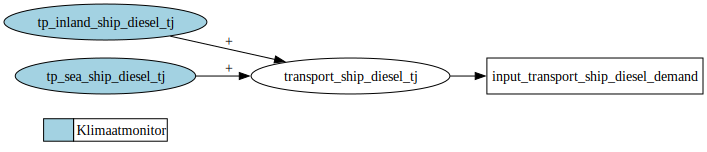

In [118]:
etlocal_key = 'input_transport_ship_diesel_demand' 
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [119]:
sector = 'transport'
output_description = 'Final diesel demand shipping'
arithmic_op= ['add','add'] #options: ['add', 'subtract', 'multiply', 'divid']
vars_description = ['the final diesel demand of inland and recreational navigation', 'the final diesel demand of fisheries']
vars_source = ['Klimaatmonitor', 'Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)


Final diesel demand shipping in the transport sector is calculated by adding the final diesel demand of inland and recreational navigation (Klimaatmonitor, 2023) to the final diesel demand of fisheries (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [120]:
df_pipeline = src.helper.generate_etlocal_key(key=etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_transport_ship_diesel_demand  transport_ship_diesel_tj  \
GemeenteCode                                                                 
GM1680                                       0.0                       0.0   
GM0358                                       4.0                       4.0   
GM0197                                       0.0                       0.0   
GM0059                                      12.0                      12.0   
GM0482                                      20.0                      20.0   
...                                          ...                       ...   
GM0879                                       0.0                       0.0   
GM0301                                       9.0                       9.0   
GM1896                                      13.0                      13.0   
GM0642                                      47.0                      47.0   
GM0193                                       5.0                       5.0   

             error_message                                             commit  
GemeenteCode                                                                   
GM1680                 NaN  Final diesel demand shipping in the transport ...  
GM0358                 NaN  Final diesel demand shipping in the transport ...  
GM0197                 NaN  Final diesel demand shipping in the transport ...  
GM0059                 NaN  Final diesel demand shipping in the transport ...  
GM0482                 NaN  Final diesel demand shipping in the transport ...  
...                    ...                                                ...  
GM0879                 NaN  Final diesel demand shipping in the transport ...  
GM0301                 NaN  Final diesel demand shipping in the transport ...  
GM1896                 NaN  Final diesel demand shipping in the transport ...  
GM0642                 NaN  Final diesel demand shipping in the transport ...  
GM0193                 NaN  Final diesel demand shipping in the transport ...  

[342 rows x 4 columns]

3. Add data to template

In [121]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local

4. Use validation function to quick-scan data

In [122]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_ship_diesel_demand',
 'total_rows': 342,
 'zero_count': 123,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 689.0,
 'mean_value': 28.68713450292398,
 'median_value': 3.0}

In [123]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_ship_diesel_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 234 municipalities (69.2%)
  exact_match: 93 municipalities (27.5%)
  medium_diff: 6 municipalities (1.8%)
  small_diff: 5 municipalities (1.5%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=689.00, Mean=28.68
  Verification: Min=0.00, Max=12622.00, Mean=156.06
  Abs diff:     Min=0.00, Max=11933.00, Mean=127.95

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=689.00, 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599           689.0              12622       11933.0     -94.541277   
GM0363           394.0               4714        4320.0     -91.641918   
GM0718           242.0               3440        3198.0     -92.965116   
GM0715           175.0               2374        2199.0     -92.628475   
GM0703           407.0               2038        1631.0     -80.029441   
...                ...                ...           ...            ...   
GM0899             0.0                  0           0.0       0.000000   
GM0450             2.0                  2           0.0       0.000000   
GM0888             0.0                  0           0.0       0.000000   
GM0882             0.0                  0           0.0       0.000000   
GM0189             0.0                  0           0.0       0.000000   

             status  
GM0599   large_diff  
GM0363   large_diff  
GM0718   large_diff  
GM0715   large_diff  
GM0703   large_diff  
...             ...  
GM0899  exact_match  
GM0450  exact_match  
GM0888  exact_match  
GM0882  exact_match  
GM0189  exact_match  

[338 rows x 5 columns]

Note: the 2023 value is much lower than the 2019 value. We (Charlotte and Claudia) have checked this and there is an descrepancy with the data. In the database of Emissieregistratie the diesel demand for shipping is *not* equal to 12600 TJ (it is in fact 557 TJ). However, the raw data that has been used calculate these 2019 values included a 12600 TJ. Emissieregistratie has been / is going to be emailed to ask them what happened.

##### Ships biodiesel demand

All fuels are attributed to diesel (for ships). Therefore the biodiesel will be set to zero for all municipalities.

In [124]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_transport_ship_biodiesel_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_transport_ship_biodiesel_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Ships electricity demand

All fuels are attributed to diesel (for ships). Therefore the electricity will be set to zero for all municipalities.

In [125]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_transport_ship_electricity_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_transport_ship_electricity_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Ships LNG demand

All fuels are attributed to diesel (for ships). Therefore the LNG will be set to zero for all municipalities.

In [126]:
# Set oil demand to zero for all municipalities
etlocal_key = 'transport_final_demand_for_shipping_lng_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'transport_final_demand_for_shipping_lng_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Ships bio-LNG demand

All fuels are attributed to diesel (for ships). Therefore the bio-LNG will be set to zero for all municipalities.

In [127]:
# Set oil demand to zero for all municipalities
etlocal_key = 'transport_final_demand_for_shipping_bio_lng_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'transport_final_demand_for_shipping_bio_lng_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Ships HFO demand

All fuels are attributed to diesel (for ships). Therefore the heavy fuel oil (HFO) will be set to zero for all municipalities.

In [128]:
# Set oil demand to zero for all municipalities
etlocal_key = 'transport_final_demand_heavy_fuel_oil_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'transport_final_demand_heavy_fuel_oil_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Aviation gasoline demand

All aviation is set to zero for all municipalities.

In [129]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_transport_plane_gasoline_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_transport_plane_gasoline_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Aviation kerosene demand

All aviation is set to zero for all municipalities.

In [130]:
# Set oil demand to zero for all municipalities
etlocal_key = 'transport_final_demand_kerosene_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'transport_final_demand_kerosene_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Aviation bio-ethanol demand

All aviation is set to zero for all municipalities.

In [131]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_transport_plane_bio_ethanol_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_transport_plane_bio_ethanol_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Aviation electricity demand

All aviation is set to zero for all municipalities.

In [132]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_transport_plane_electricity_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_transport_plane_electricity_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Area attributes > number of cars

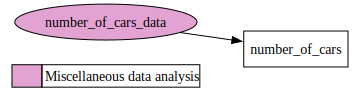

In [133]:
etlocal_key = 'number_of_cars'
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [134]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)

In [135]:
message = "Aantal wegvoertuigen - Personenauto (CBS, 2022), 2023 is no longer available."
print(message)
df_pipeline['commit'] = message

Aantal wegvoertuigen - Personenauto (CBS, 2022), 2023 is no longer available.


Add data to template

In [136]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

unit     value  \
geo_id group     subgroup                                  
GM0014 transport transport_road_transport    #   97287.0   
GM0034 transport transport_road_transport    #  258677.0   
GM0037 transport transport_road_transport    #   17836.0   
GM0047 transport transport_road_transport    #   15515.0   
GM0050 transport transport_road_transport    #   12579.0   
...                                        ...       ...   
GM1979 transport transport_road_transport    #   24198.0   
GM1980 transport transport_road_transport    #   44840.0   
GM1982 transport transport_road_transport    #   52033.0   
GM1991 transport transport_road_transport    #   35218.0   
GM1992 transport transport_road_transport    #   40724.0   

                                                                                      commit  
geo_id group     subgroup                                                                     
GM0014 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM0034 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM0037 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM0047 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM0050 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
...                                                                                      ...  
GM1979 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM1980 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM1982 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM1991 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  
GM1992 transport transport_road_transport  Aantal wegvoertuigen - Personenauto (CBS, 2022...  

[342 rows x 3 columns]

Use validation function to quick-scan data

In [137]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'number_of_cars',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 355.0,
 'max_value': 258677.0,
 'mean_value': 26118.874269005846,
 'median_value': 17489.0}

In [138]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: number_of_cars
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  medium_diff: 320 municipalities (94.7%)
  large_diff: 14 municipalities (4.1%)
  small_diff: 4 municipalities (1.2%)

 VALUE STATISTICS:
  Template:     Min=355.00, Max=258677.00, Mean=25916.69
  Verification: Min=340.00, Max=270555.00, Mean=24716.07
  Abs diff:     Min=15.00, Max=19156.00, Mean=1367.61

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=244366.00, Verification=225210.00, Diff=19156.00 (8.5

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599        244366.0             225210       19156.0       8.505839   
GM0321         73318.0              55225       18093.0      32.762336   
GM0307        124805.0             108630       16175.0      14.889994   
GM0363        249771.0             235025       14746.0       6.274226   
GM0034        258677.0             270555       11878.0      -4.390235   
...                ...                ...           ...            ...   
GM0569         16113.0              16185          72.0      -0.444856   
GM0981          4943.0               4875          68.0       1.394872   
GM0406         22066.0              22120          54.0      -0.244123   
GM0415          5678.0               5655          23.0       0.406720   
GM0088           355.0                340          15.0       4.411765   

             status  
GM0599  medium_diff  
GM0321   large_diff  
GM0307   large_diff  
GM0363  medium_diff  
GM0034  medium_diff  
...             ...  
GM0569   small_diff  
GM0981  medium_diff  
GM0406   small_diff  
GM0415   small_diff  
GM0088  medium_diff  

[338 rows x 5 columns]

##### Area attributes > number of buses

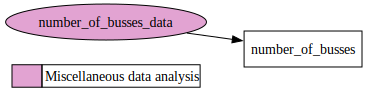

In [139]:
etlocal_key = 'number_of_busses'
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [140]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)

In [141]:
message = "Aantal wegvoertuigen - Bus (excluding tractor units for semi-trailers) (CBS, 2022), 2023 is no longer available."
print(message)
df_pipeline['commit'] = message

Aantal wegvoertuigen - Bus (excluding tractor units for semi-trailers) (CBS, 2022), 2023 is no longer available.


Add data to template

In [142]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

unit  value  \
geo_id group     subgroup                               
GM0014 transport transport_road_transport    #  308.0   
GM0034 transport transport_road_transport    #   21.0   
GM0037 transport transport_road_transport    #    2.0   
GM0047 transport transport_road_transport    #    0.0   
GM0050 transport transport_road_transport    #    0.0   
...                                        ...    ...   
GM1979 transport transport_road_transport    #    1.0   
GM1980 transport transport_road_transport    #    5.0   
GM1982 transport transport_road_transport    #   13.0   
GM1991 transport transport_road_transport    #    9.0   
GM1992 transport transport_road_transport    #    2.0   

                                                                                      commit  
geo_id group     subgroup                                                                     
GM0014 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM0034 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM0037 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM0047 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM0050 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
...                                                                                      ...  
GM1979 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM1980 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM1982 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM1991 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  
GM1992 transport transport_road_transport  Aantal wegvoertuigen - Bus (excluding tractor ...  

[342 rows x 3 columns]

Use validation function to quick-scan data

In [143]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'number_of_busses',
 'total_rows': 342,
 'zero_count': 72,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 1414.0,
 'mean_value': 26.482456140350877,
 'median_value': 4.0}

In [144]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: number_of_busses
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 189 municipalities (55.9%)
  exact_match: 105 municipalities (31.1%)
  medium_diff: 33 municipalities (9.8%)
  small_diff: 11 municipalities (3.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1414.00, Mean=26.71
  Verification: Min=0.00, Max=1371.00, Mean=28.63
  Abs diff:     Min=0.00, Max=277.00, Mean=7.64

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0687: Template=4.00, Verification=281.00, D

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0687             4.0                281         277.0     -98.576512   
GM0014           308.0                 51         257.0     503.921569   
GM0307           613.0                854         241.0     -28.220141   
GM0074          1180.0               1323         143.0     -10.808768   
GM1961           191.0                 81         110.0     135.802469   
...                ...                ...           ...            ...   
GM1525             1.0                  1           0.0       0.000000   
GM1509             0.0                  0           0.0       0.000000   
GM0736             7.0                  7           0.0       0.000000   
GM0995            10.0                 10           0.0       0.000000   
GM0473             1.0                  1           0.0       0.000000   

             status  
GM0687   large_diff  
GM0014   large_diff  
GM0307   large_diff  
GM0074   large_diff  
GM1961   large_diff  
...             ...  
GM1525  exact_match  
GM1509  exact_match  
GM0736  exact_match  
GM0995  exact_match  
GM0473  exact_match  

[338 rows x 5 columns]

##### Area attributes > number of trucks

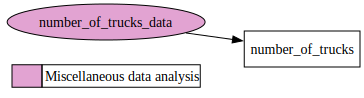

In [145]:
etlocal_key = 'number_of_trucks'
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [146]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)

In [147]:
message = "Aantal wegvoertuigen - Vrachtauto (excl. trekker voor oplegger) (CBS, 2022), 2023 is no longer available."
print(message)
df_pipeline['commit'] = message

Aantal wegvoertuigen - Vrachtauto (excl. trekker voor oplegger) (CBS, 2022), 2023 is no longer available.


Add data to template

In [148]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

unit  value  \
geo_id group     subgroup                               
GM0014 transport transport_road_transport    #  412.0   
GM0034 transport transport_road_transport    #  658.0   
GM0037 transport transport_road_transport    #  123.0   
GM0047 transport transport_road_transport    #   72.0   
GM0050 transport transport_road_transport    #   98.0   
...                                        ...    ...   
GM1979 transport transport_road_transport    #   77.0   
GM1980 transport transport_road_transport    #  275.0   
GM1982 transport transport_road_transport    #  614.0   
GM1991 transport transport_road_transport    #  502.0   
GM1992 transport transport_road_transport    #  132.0   

                                                                                      commit  
geo_id group     subgroup                                                                     
GM0014 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM0034 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM0037 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM0047 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM0050 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
...                                                                                      ...  
GM1979 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM1980 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM1982 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM1991 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  
GM1992 transport transport_road_transport  Aantal wegvoertuigen - Vrachtauto (excl. trekk...  

[342 rows x 3 columns]

Use validation function to quick-scan data

In [149]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'number_of_trucks',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 4.0,
 'max_value': 1533.0,
 'mean_value': 183.4795321637427,
 'median_value': 128.0}

In [150]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: number_of_trucks
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  medium_diff: 204 municipalities (60.4%)
  large_diff: 109 municipalities (32.2%)
  small_diff: 18 municipalities (5.3%)
  exact_match: 7 municipalities (2.1%)

 VALUE STATISTICS:
  Template:     Min=4.00, Max=1533.00, Mean=181.14
  Verification: Min=3.00, Max=1315.00, Mean=181.01
  Abs diff:     Min=0.00, Max=218.00, Mean=14.81

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0772: Template=1533.00, Verification=1315

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0772          1533.0               1315         218.0      16.577947   
GM0394          1098.0               1269         171.0     -13.475177   
GM0599          1226.0               1073         153.0      14.259087   
GM0855           777.0                653         124.0      18.989280   
GM0503           106.0                197          91.0     -46.192893   
...                ...                ...           ...            ...   
GM0737           166.0                166           0.0       0.000000   
GM1669            56.0                 56           0.0       0.000000   
GM0417            12.0                 12           0.0       0.000000   
GM0845           167.0                167           0.0       0.000000   
GM0882            93.0                 93           0.0       0.000000   

             status  
GM0772   large_diff  
GM0394   large_diff  
GM0599   large_diff  
GM0855   large_diff  
GM0503   large_diff  
...             ...  
GM0737  exact_match  
GM1669  exact_match  
GM0417  exact_match  
GM0845  exact_match  
GM0882  exact_match  

[338 rows x 5 columns]

##### Area attributes > number of vans

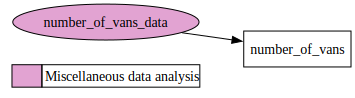

In [151]:
etlocal_key = 'number_of_vans'
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [152]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)

In [153]:
message = "Aantal wegvoertuigen - Bestelauto (CBS, 2022), 2023 is no longer available."
print(message)
df_pipeline['commit'] = message

Aantal wegvoertuigen - Bestelauto (CBS, 2022), 2023 is no longer available.


Add data to template

In [154]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

unit    value  \
geo_id group     subgroup                                 
GM0014 transport transport_road_transport    #  11095.0   
GM0034 transport transport_road_transport    #  31940.0   
GM0037 transport transport_road_transport    #   2459.0   
GM0047 transport transport_road_transport    #   1539.0   
GM0050 transport transport_road_transport    #   1430.0   
...                                        ...      ...   
GM1979 transport transport_road_transport    #   2504.0   
GM1980 transport transport_road_transport    #   4588.0   
GM1982 transport transport_road_transport    #   5881.0   
GM1991 transport transport_road_transport    #   5610.0   
GM1992 transport transport_road_transport    #   3281.0   

                                                                                      commit  
geo_id group     subgroup                                                                     
GM0014 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM0034 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM0037 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM0047 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM0050 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
...                                                                                      ...  
GM1979 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM1980 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM1982 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM1991 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  
GM1992 transport transport_road_transport  Aantal wegvoertuigen - Bestelauto (CBS, 2022),...  

[342 rows x 3 columns]

Use validation function to quick-scan data

In [155]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'number_of_vans',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 32.0,
 'max_value': 31940.0,
 'mean_value': 2893.9590643274855,
 'median_value': 2112.5}

In [156]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: number_of_vans
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  medium_diff: 203 municipalities (60.1%)
  large_diff: 124 municipalities (36.7%)
  small_diff: 10 municipalities (3.0%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=32.00, Max=31940.00, Mean=2870.93
  Verification: Min=32.00, Max=34576.00, Mean=2644.10
  Abs diff:     Min=0.00, Max=3474.00, Mean=271.31

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=23553.00, Verificati

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0599         23553.0              20079        3474.0      17.301658   
GM0394         20457.0              17376        3081.0      17.731354   
GM0034         31940.0              34576        2636.0      -7.623785   
GM0307         17202.0              14728        2474.0      16.797936   
GM0321          8749.0               6391        2358.0      36.895634   
...                ...                ...           ...            ...   
GM0141          3787.0               3790           3.0      -0.079156   
GM0281          2874.0               2871           3.0       0.104493   
GM0373          1395.0               1397           2.0      -0.143164   
GM0308           935.0                934           1.0       0.107066   
GM0277            32.0                 32           0.0       0.000000   

             status  
GM0599   large_diff  
GM0394   large_diff  
GM0034  medium_diff  
GM0307   large_diff  
GM0321   large_diff  
...             ...  
GM0141   small_diff  
GM0281   small_diff  
GM0373   small_diff  
GM0308   small_diff  
GM0277  exact_match  

[338 rows x 5 columns]

##### Human powered bicycle

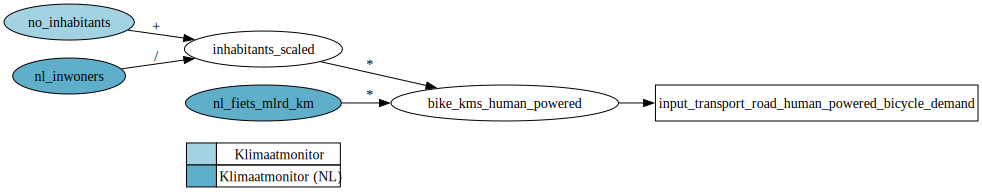

In [157]:
etlocal_key = 'input_transport_road_human_powered_bicycle_demand'
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram


In [158]:
# message = 'Number of road vehicles – Trucks (excluding tractor units for semi-trailers) (CBS, 2022), 2023 data is no longer available.'
message = 'Distance travelled by bicycle is based on the national dataset (CBS, 2023: https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84687NED/table?dl=5526A) multiplied by the municipal share based on the number of inhabitants.'
print(message)
df_pipeline['commit'] = message


Distance travelled by bicycle is based on the national dataset (CBS, 2023: https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84687NED/table?dl=5526A) multiplied by the municipal share based on the number of inhabitants.


Add data to template

In [159]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

unit         value  \
geo_id group     subgroup                                      
GM0014 transport transport_road_transport   km  2.379960e+08   
GM0034 transport transport_road_transport   km  2.226837e+08   
GM0037 transport transport_road_transport   km  3.211463e+07   
GM0047 transport transport_road_transport   km  2.759849e+07   
GM0050 transport transport_road_transport   km  2.367698e+07   
...                                        ...           ...   
GM1979 transport transport_road_transport   km  4.536522e+07   
GM1980 transport transport_road_transport   km  8.892859e+07   
GM1982 transport transport_road_transport   km  9.136504e+07   
GM1991 transport transport_road_transport   km  5.889664e+07   
GM1992 transport transport_road_transport   km  7.389812e+07   

                                                                                      commit  
geo_id group     subgroup                                                                     
GM0014 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM0034 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM0037 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM0047 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM0050 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
...                                                                                      ...  
GM1979 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM1980 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM1982 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM1991 transport transport_road_transport  Distance travelled by bicycle is based on the ...  
GM1992 transport transport_road_transport  Distance travelled by bicycle is based on the ...  

[342 rows x 3 columns]

Use validation function to quick-scan data

In [160]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_transport_road_human_powered_bicycle_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 981377.4868986196,
 'max_value': 917534983.8481668,
 'mean_value': 52046783.62573099,
 'median_value': 32483894.62616719}

In [161]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_transport_road_human_powered_bicycle_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=981377.49, Max=917534983.85, Mean=51736424.85
  Verification: Min=659667.43, Max=608194338.90, Mean=35343324.23
  Abs diff:     Min=321710.06, Max=309340644.95, Mean=16393100.62

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0363: Template=917534983.85, Verification=608194338.90, Diff=309340644.95 (50.9%

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value     absolute_diff  relative_diff  \
GM0363    9.175350e+08        608194338.9  309340644.948167      50.862138   
GM0599    6.634791e+08        454309292.2  209169845.836653      46.041287   
GM0518    5.624822e+08        379050118.9  183432084.102579      48.392567   
GM0344    3.677137e+08        248690391.4  119023358.265872      47.860055   
GM0772    2.435755e+08        163255002.3   80320491.469654      49.199406   
...                ...                ...               ...            ...   
GM0093    4.924876e+06        3446339.443    1478536.580866      42.901653   
GM0060    3.837566e+06        2588630.833    1248934.899883      48.246930   
GM0277    1.752888e+06        1165694.364      587193.73378      50.372872   
GM0096    1.290182e+06        802031.5513     488150.053167      60.864196   
GM0088    9.813775e+05         659667.427     321710.059899      48.768523   

            status  
GM0363  large_diff  
GM0599  large_diff  
GM0518  large_diff  
GM0344  large_diff  
GM0772  large_diff  
...            ...  
GM0093  large_diff  
GM0060  large_diff  
GM0277  large_diff  
GM0096  large_diff  
GM0088  large_diff  

[338 rows x 5 columns]

## Export
Write the resulting filled template to a csv

In [162]:
# Write the filled template to a CSV file
path_output = Path("data", "processed", f"etlocal_template_transport_filled.csv")
df_template_local.to_csv(path_output, sep=sep)
